In [42]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.stats.api as sms

%matplotlib inline

In [39]:
df = dw.td_query('''
SELECT
    shipping_country 
    ,dim_delivery_program
    ,registered
    ,TD_TIME_FORMAT(order_time,'yyyy-MM','America/Los_Angeles') as order_month
    ,max_shipping_time_shown AS shown_ship_time
    ,CEIL((COALESCE(delivered, user_confirmed_delivery) - order_time) / (3600*24)) AS actual_ship_time
    
    ,count(m_transaction_id) AS transactions
    ,count(refunded_time) AS refunds
    ,sum(if(refund_reason_category in (20,35,38), 1, 0)) AS logistics_refund
    ,round(100*count(refunded_time)/count(m_transaction_id),2) as overall_refund_rate
    ,round(100*sum(if(refund_reason_category in (20,35,38), 1, 0))/count(m_transaction_id),2) as logistics_refund_rate
    
FROM analytics.jay_ttd_refund_analysis_2
-- WHERE 
GROUP BY 1,2,3,4,5,6
-- order by TD_TIME_FORMAT(order_time,'yyyy-MM','America/Los_Angeles') asc
'''
,job_id=714262814
                )

You can look at job id 714262814


In [40]:
df.head()

shipping_country dim_delivery_program    registered order_month  \
0               US                  EPC          true     2019-11   
1               ES             Dropship  Non Wishpost     2019-11   
2               US                  FBW  Non Wishpost     2020-02   
3               US             Dropship  Non Wishpost     2019-12   
4               ES                  FBW  Non Wishpost     2020-01   

   shown_ship_time  actual_ship_time  transactions  refunds  logistics_refund  \
0             20.0              19.0         25511      519               166   
1             27.0               NaN         41370    11795             11233   
2             64.0               NaN         18303      165                 0   
3             33.0              25.0           806       56                 0   
4             35.0              30.0             5        0                 0   

   overall_refund_rate  logistics_refund_rate  
0                    2                      0  
1                   28                     27  
2                    0                      0  
3                    6                      0  
4                    0                      0

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1239856 entries, 0 to 1239855
Data columns (total 11 columns):
shipping_country         1239850 non-null object
dim_delivery_program     1239856 non-null object
registered               1165793 non-null object
order_month              1239856 non-null object
shown_ship_time          1239850 non-null float64
actual_ship_time         1178140 non-null float64
transactions             1239856 non-null int64
refunds                  1239856 non-null int64
logistics_refund         1239856 non-null int64
overall_refund_rate      1239856 non-null int64
logistics_refund_rate    1239856 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 104.1+ MB


In [70]:
df.loc[:, 'time_diff'] = df.actual_ship_time - df.shown_ship_time
df.loc[df.time_diff<-5, 'time_diff'] = -5
df.loc[df.time_diff > 30, 'time_diff'] = 30
# df.loc[df.time_diff.isna(), 'time_diff'] = 40


## logsitics refund rate: with and without delivery signal

In [104]:
def t_test(x, y , metrics_name = 'logistics_refund_rate', alpha=0.05):
    
    print('---------------------------------------------------------------------------------------------------')
    
    mask1 = x.notna()
    mask2 = y.notna()
    w_delivery = x[mask1]
    wo_delivery = y[mask2]
    
    t_stat, p_value = stats.ttest_ind(w_delivery,wo_delivery)
    t_stat_welch, p_value_welch = stats.ttest_ind(w_delivery,wo_delivery,equal_var=False)
    
    
    with_mean = w_delivery.mean()
    without_mean = wo_delivery.mean()
    
    lower_with, upper_with = sms.DescrStatsW(w_delivery).tconfint_mean(alpha=alpha)
    lower_without, upper_without = sms.DescrStatsW(wo_delivery).tconfint_mean(alpha=alpha)
    is_95CI_overlap = (lower_with <= upper_without and lower_with>=lower_without) or (upper_with >= lower_without and upper_with<= upper_without)
    
    print("Below is the t-test summary of kpi - %s, with delivery and without delivery signal groups:" %metrics_name)
    print('\n')
    print( "The mean of kpi - %s, is %5.2f for with delivery signal, and %5.2f for without delivery signal" % (metrics_name, with_mean, without_mean) )
    print( "The %i%% CI of kpi - %s, is [%6.3f,%6.3f] for with delivery signal" % (100-100*alpha ,metrics_name, lower_with, upper_with) )
    print( "The %i%% CI of kpi - %s, is [%6.3f,%6.3f] for without delivery signal" % (100-100*alpha , metrics_name, lower_without, upper_without) )
    print('\n')
    print( "Does the %i%% CI of kpi - %s overlap across with and without delivery signal groups? %s" %(100-100*alpha, metrics_name, str(is_95CI_overlap).upper()) )
    print('\n')
    print("Classic t statistics is: %4.2f with p-value : %4.2f" % (t_stat,p_value))
    if p_value<=alpha:
        print("Which means the difference on kpi - %s is significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
    else:
        print("Which means the difference on kpi - %s is NOT significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
    print('\n')
    
    print("Welch t statistics is: %4.2f with p-value : %4.2f" % (t_stat_welch,p_value_welch))
    if p_value_welch<=alpha:
        print("Which means the difference on kpi - %s is significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
    else:
        print("Which means the difference on kpi - %s is NOT significant at Type-I error = %4.2f %% level" %(metrics_name,alpha*100))
        
    
    print('---------------------------------------------------------------------------------------------------')

In [105]:
mask1 = df.actual_ship_time.notna()
mask2 = df.actual_ship_time.isna()

with_delivery_signal = df.loc[mask1,'logistics_refund_rate']
wo_delivery_signal = df.loc[mask2,'logistics_refund_rate']

t_test(with_delivery_signal, wo_delivery_signal, metrics_name = 'logistics_refund_rate')

---------------------------------------------------------------------------------------------------
Below is the t-test summary of kpi - logistics_refund_rate, with delivery and without delivery signal groups:


The mean of kpi - logistics_refund_rate, is  4.61 for with delivery signal, and 10.07 for without delivery signal
The 95% CI of kpi - logistics_refund_rate, is [ 4.584, 4.644] for with delivery signal
The 95% CI of kpi - logistics_refund_rate, is [ 9.942,10.202] for without delivery signal


Does the 95% CI of kpi - logistics_refund_rate overlap across with and without delivery signal groups? FALSE


Classic t statistics is: -79.25 with p-value : 0.00
Which means the difference on kpi - logistics_refund_rate is significant at Type-I error = 5.00 % level


Welch t statistics is: -80.23 with p-value : 0.00
Which means the difference on kpi - logistics_refund_rate is significant at Type-I error = 5.00 % level
------------------------------------------------------------------------

In [145]:
mask1 = df.actual_ship_time.notna()
mask2 = df.actual_ship_time.isna()
mask3 = df.dim_delivery_program == "Dropship"

with_delivery_signal = df.loc[mask1 & mask3,'logistics_refund_rate']
wo_delivery_signal = df.loc[mask2 & mask3,'logistics_refund_rate']

t_test(with_delivery_signal, wo_delivery_signal, metrics_name = 'logistics_refund_rate')

---------------------------------------------------------------------------------------------------
Below is the t-test summary of kpi - logistics_refund_rate, with delivery and without delivery signal groups:


The mean of kpi - logistics_refund_rate, is  5.40 for with delivery signal, and  8.57 for without delivery signal
The 95% CI of kpi - logistics_refund_rate, is [ 5.357, 5.438] for with delivery signal
The 95% CI of kpi - logistics_refund_rate, is [ 8.410, 8.738] for without delivery signal


Does the 95% CI of kpi - logistics_refund_rate overlap across with and without delivery signal groups? FALSE


Classic t statistics is: -30.33 with p-value : 0.00
Which means the difference on kpi - logistics_refund_rate is significant at Type-I error = 5.00 % level


Welch t statistics is: -36.92 with p-value : 0.00
Which means the difference on kpi - logistics_refund_rate is significant at Type-I error = 5.00 % level
------------------------------------------------------------------------

## Overall logistics refund rate: slice by top 10 Countries

In [ ]:
c = df.groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
c.loc[:, 'lrr'] = round(100*c.logistics_refund / c.transactions,2)
c.loc[:, 'overall_rr'] = round(100*c.refunds / c.transactions,2)

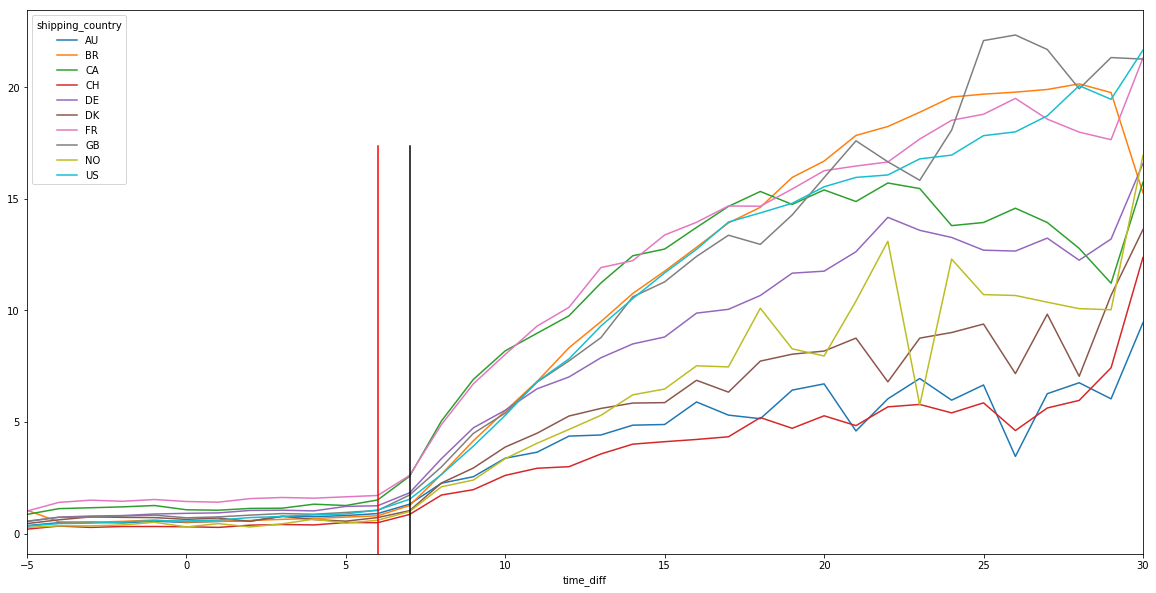

In [38]:
countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
pvt = c.loc[c.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
pvt.plot(figsize=(20,10))
plt.axvline(7, 0, 0.75, color='black')
plt.axvline(6, 0, 0.75, color='red')

## Oveall logistics refund rate: slice by bucket

In [ ]:
shown = [(0,10), (10,20), (20,30), (30,40), (40,50), (50, 300)]
m = 2
n = (len(shown)+1) // 2
fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
for i in range(len(shown)):
    mins, maxs = shown[i]
    c = df.loc[(df.shown_ship_time>mins)&
               (df.shown_ship_time<maxs), :].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'logistics_refund'].sum()
    c.loc[:, 'lrr'] = c.logistics_refund / c.transactions
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU', 'CA']
    pvt = c.loc[(c.shipping_country.isin(countries)), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    x = i//m
    y = i%m
    pvt.plot(ax=axes[x][y],
             title='LRR by time diff for shown TTD between {}~{} day'.format(mins, maxs),
             ylim=(0,.5))

## Overall logistics refund rate: slice by month

In [118]:
# month_list = list(set(df.order_month))
month_list = ['2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03']
# a = month_list.sort()
# print(a)

<Figure size 432x288 with 0 Axes>

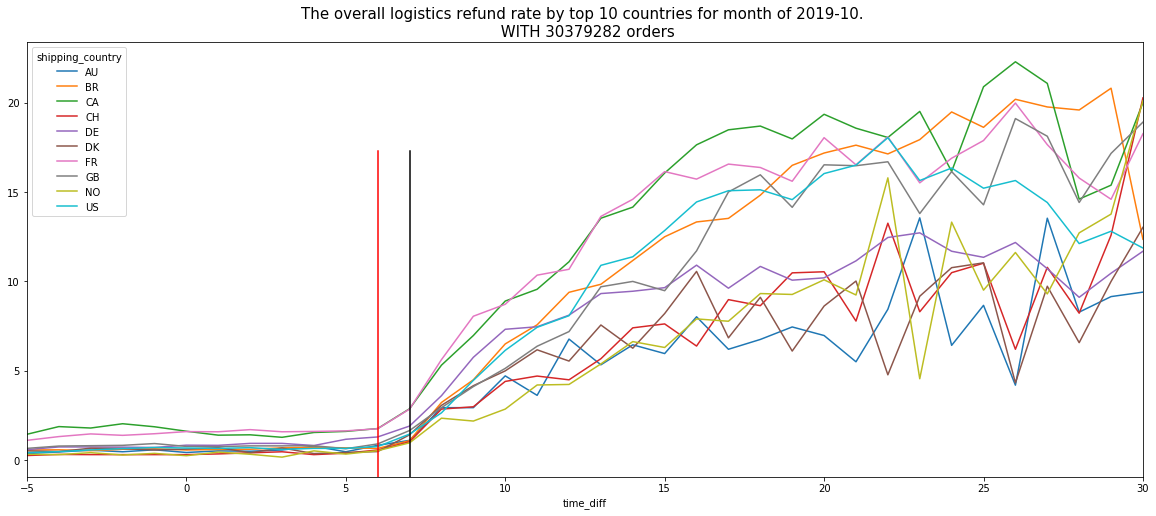

<Figure size 432x288 with 0 Axes>

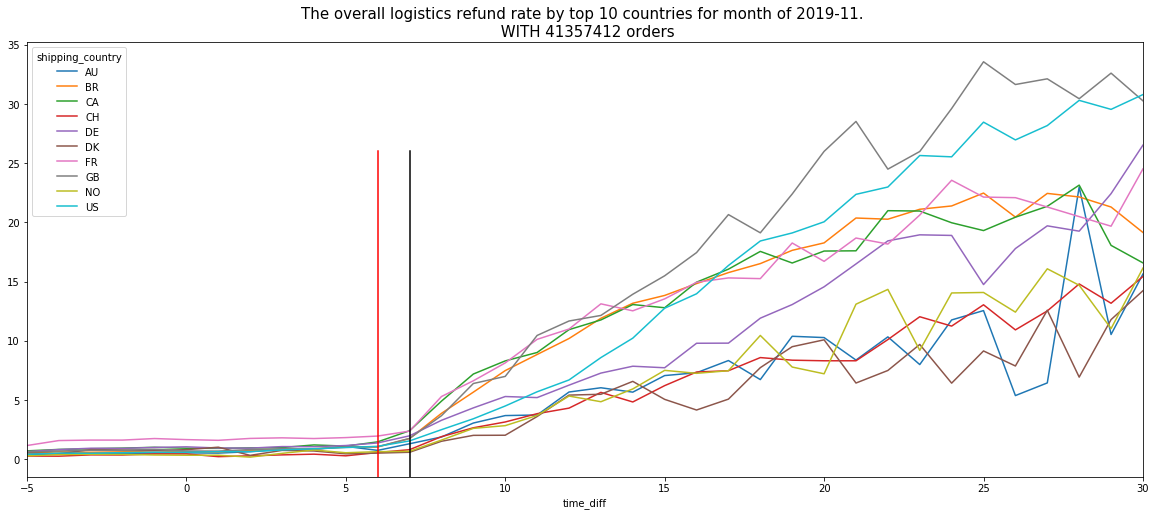

<Figure size 432x288 with 0 Axes>

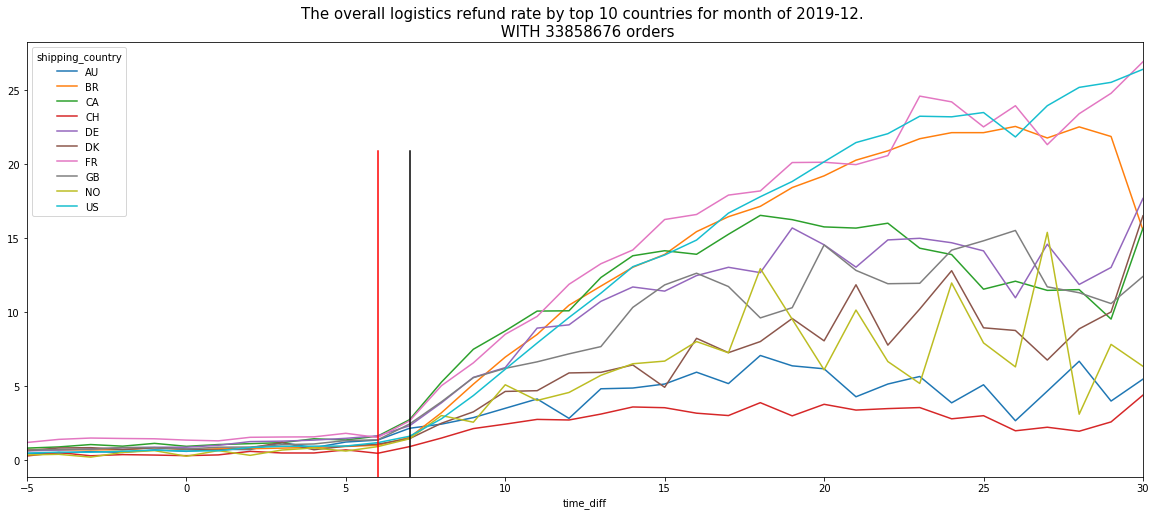

<Figure size 432x288 with 0 Axes>

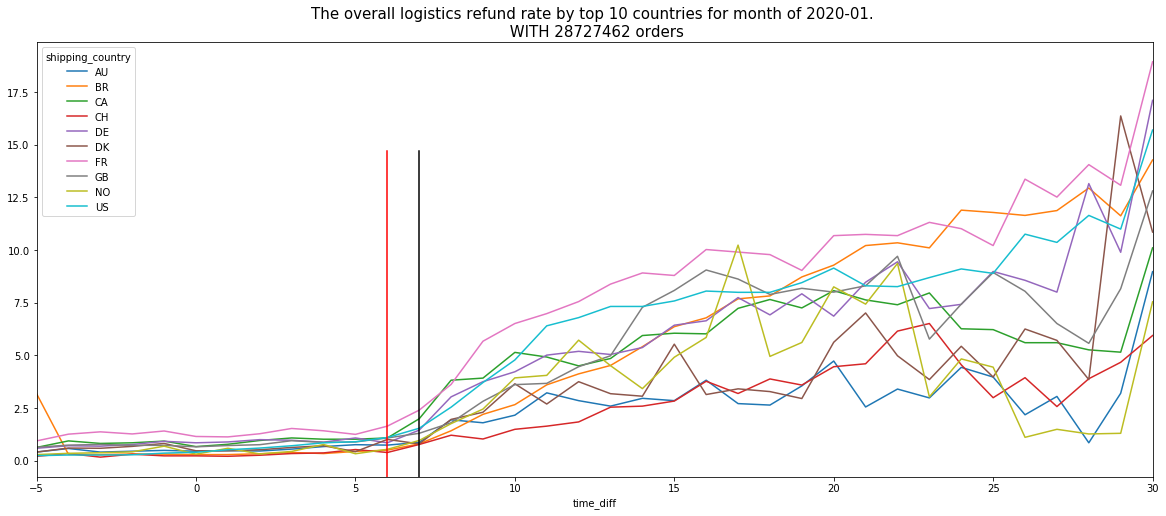

<Figure size 432x288 with 0 Axes>

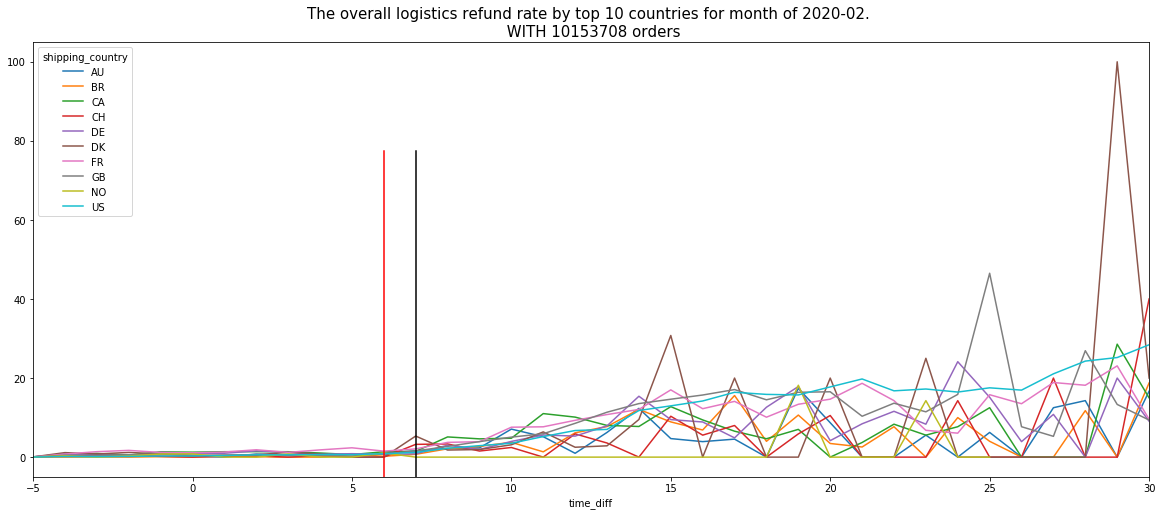

<Figure size 432x288 with 0 Axes>

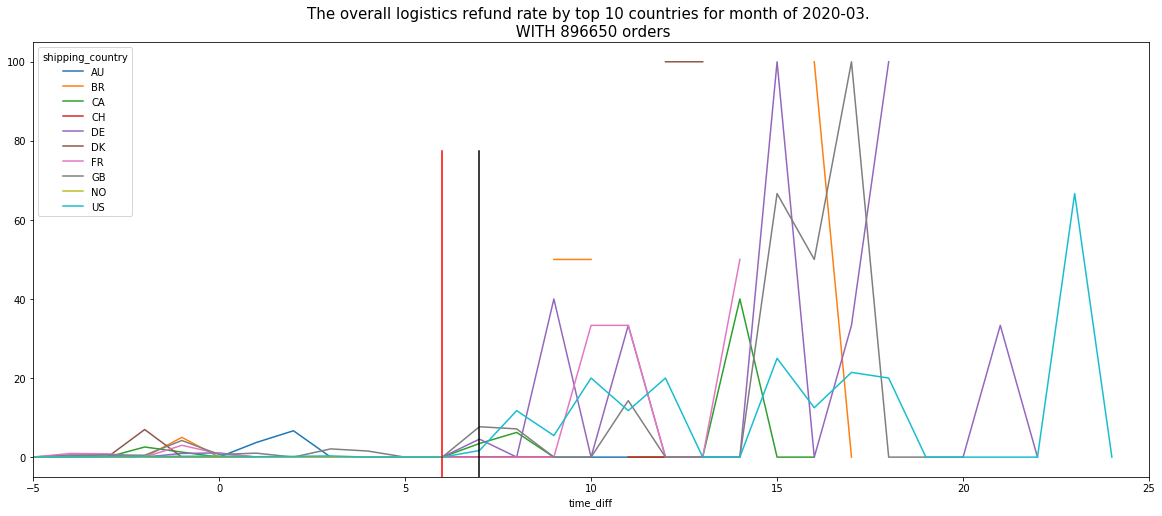

In [126]:
for month in month_list:
    df_month = df.loc[df.order_month==month,:].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
    df_month.loc[:, 'lrr'] = round(100*df_month.logistics_refund / df_month.transactions,2)
    df_month.loc[:, 'overall_rr'] = round(100*df_month.refunds / df_month.transactions,2)
    pvt = df_month.loc[df_month.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
    order_count = sum(df_month.transactions)
    
    plt.figure()
    pvt.plot(figsize=(20,8))
    plt.title('The overall logistics refund rate by top 10 countries for month of %s. \n WITH %s orders' %(month,order_count), size = 15)
    plt.axvline(7, 0, 0.75, color='black')
    plt.axvline(6, 0, 0.75, color='red')
    
    plt.show()

## Overall logistics refund rate: slice by registered mail or not

In [133]:
registered = list(set(df.registered))
registered

['false', 'true', 'Non Wishpost', None]

<Figure size 432x288 with 0 Axes>

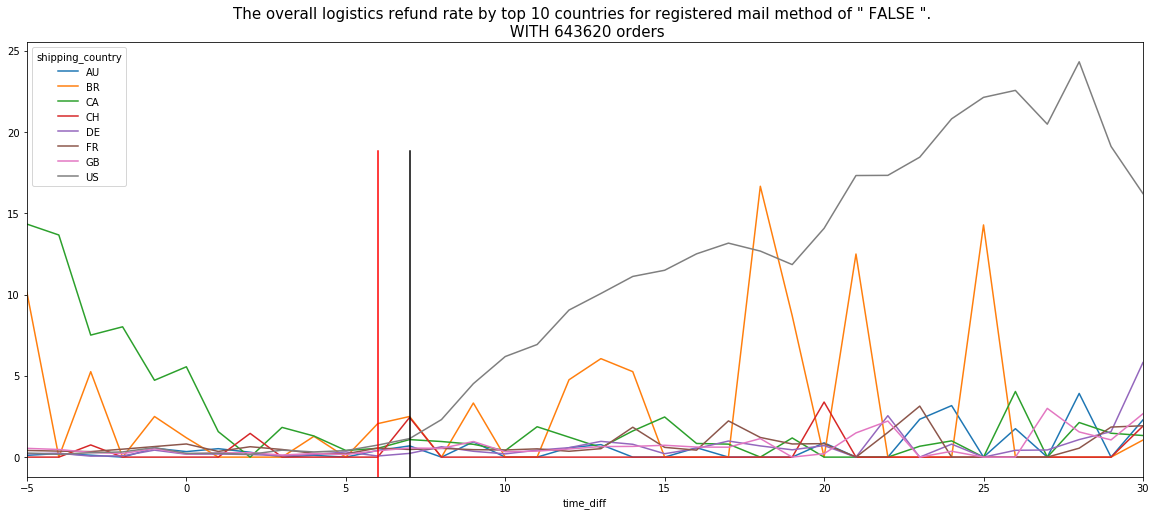

<Figure size 432x288 with 0 Axes>

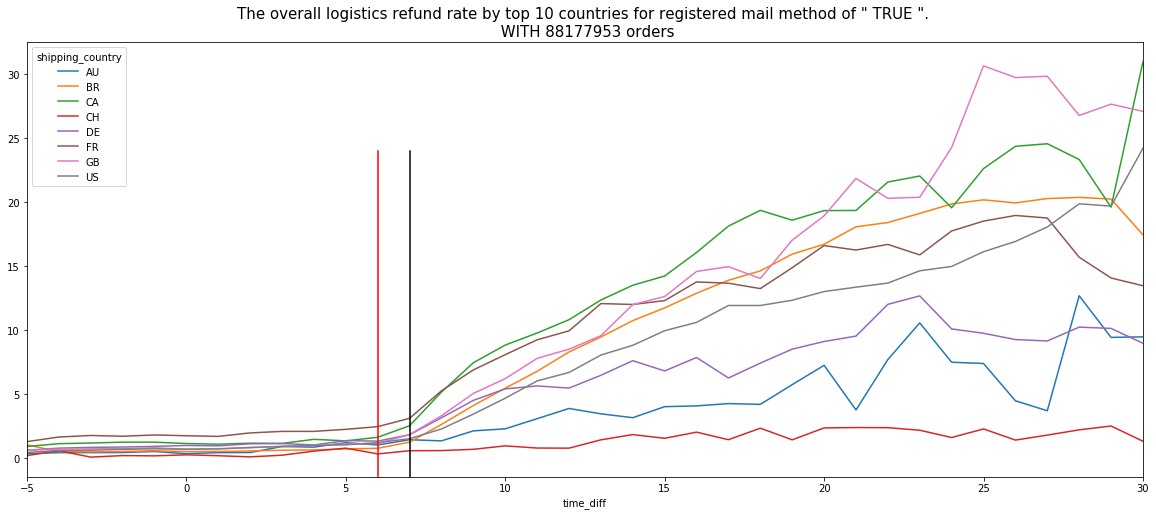

<Figure size 432x288 with 0 Axes>

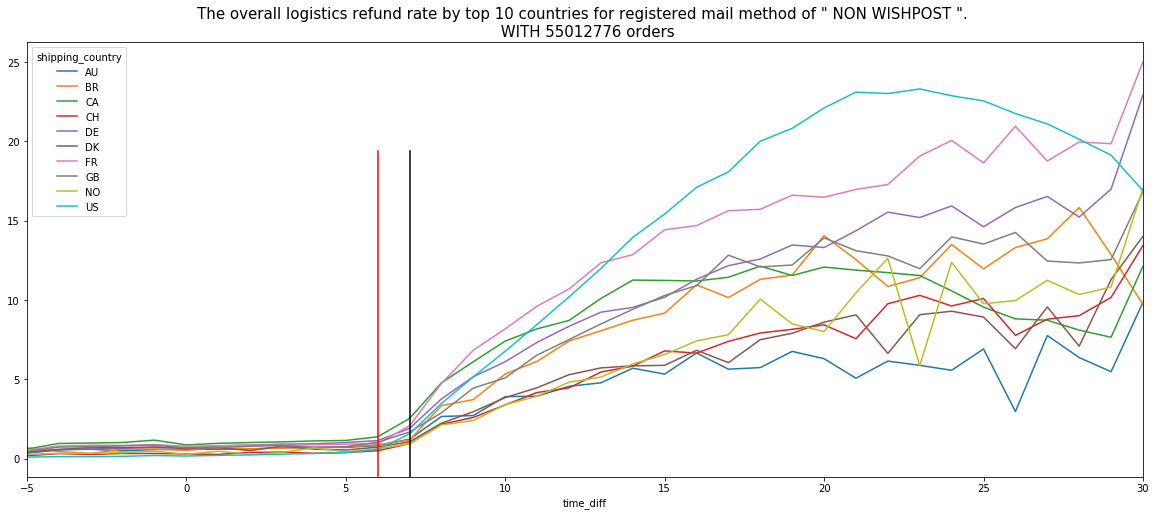

In [138]:
for register in registered[0:3]:
    df_month = df.loc[df.registered==register,:].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
    df_month.loc[:, 'lrr'] = round(100*df_month.logistics_refund / df_month.transactions,2)
    df_month.loc[:, 'overall_rr'] = round(100*df_month.refunds / df_month.transactions,2)
    pvt = df_month.loc[df_month.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
    order_count = sum(df_month.transactions)
    
    plt.figure()
    pvt.plot(figsize=(20,8))
    plt.title('The overall logistics refund rate by top 10 countries for registered mail method of " %s ". \n WITH %s orders' %(register.upper(),order_count), size = 15)
    plt.axvline(7, 0, 0.75, color='black')
    plt.axvline(6, 0, 0.75, color='red')
    
    plt.show()

## Overall logistics refund rate: slice by delivery program such as EPC, Dropship, A+ and so on

In [140]:
c = list(set(df.dim_delivery_program))
delivery_program

['A+', 'Wish_Express', 'EPC', 'Dropship', 'Fusion', 'FBW']

<Figure size 432x288 with 0 Axes>

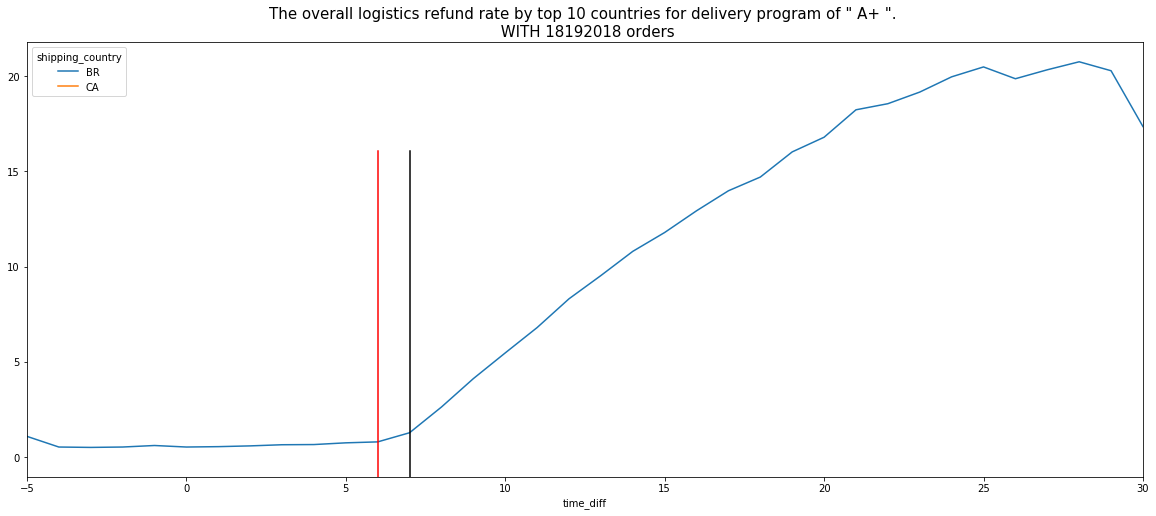

<Figure size 432x288 with 0 Axes>

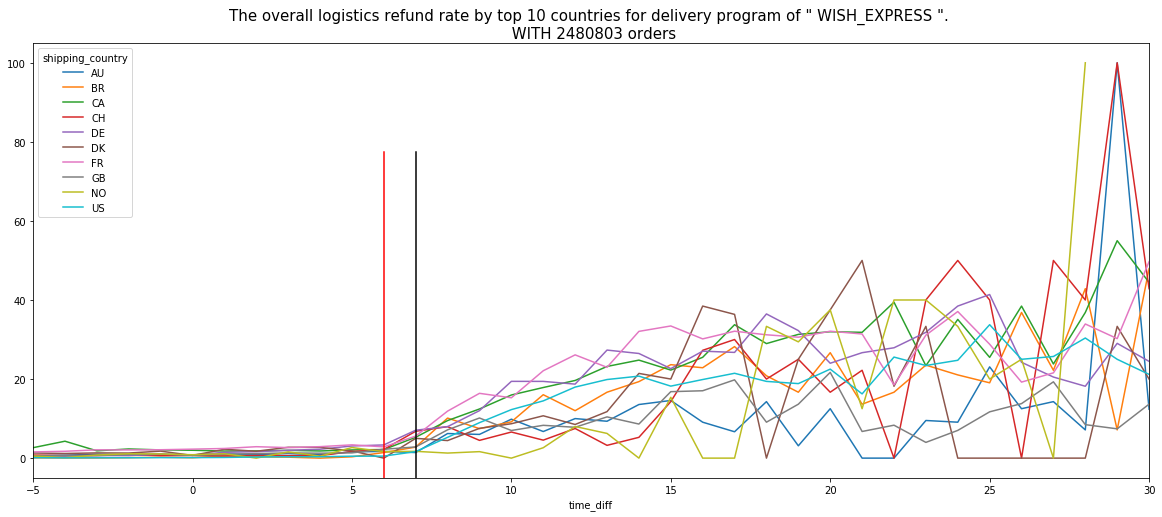

<Figure size 432x288 with 0 Axes>

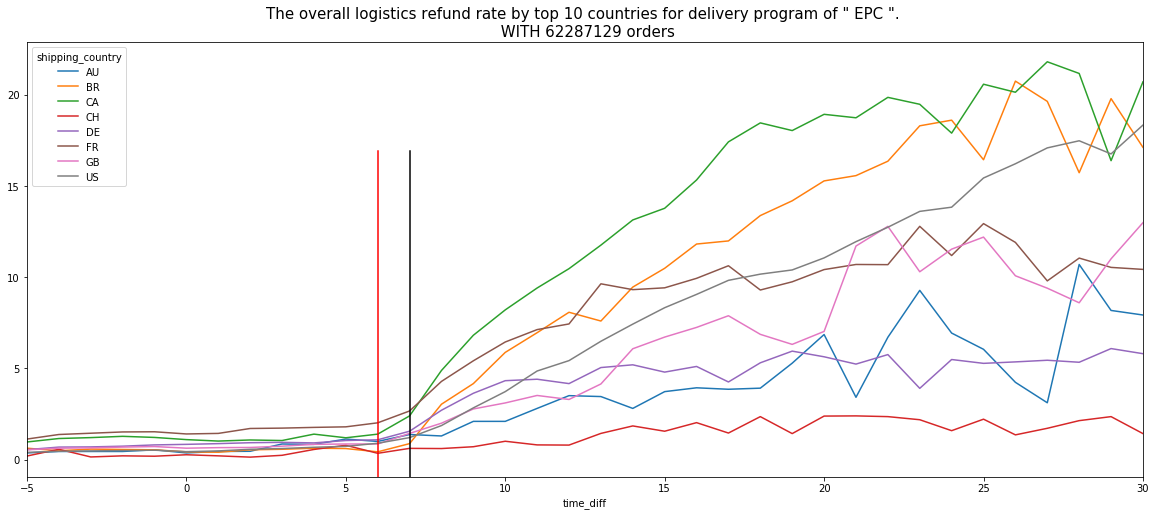

<Figure size 432x288 with 0 Axes>

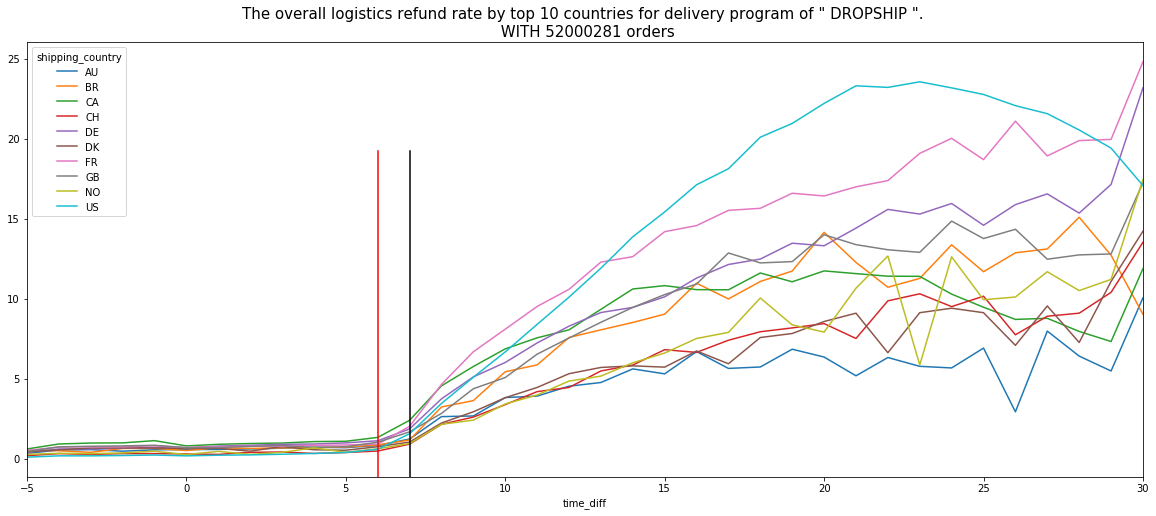

<Figure size 432x288 with 0 Axes>

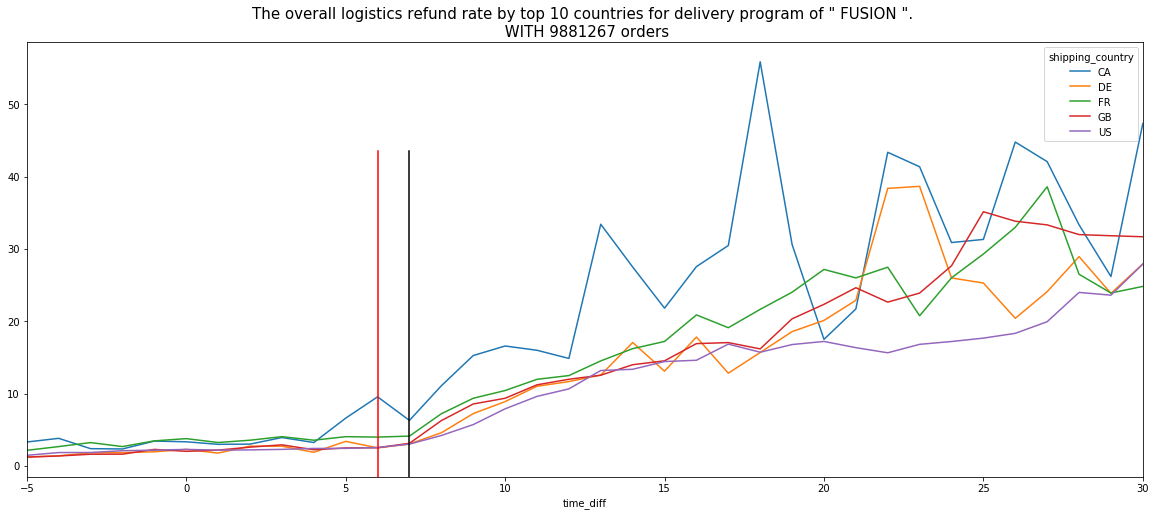

<Figure size 432x288 with 0 Axes>

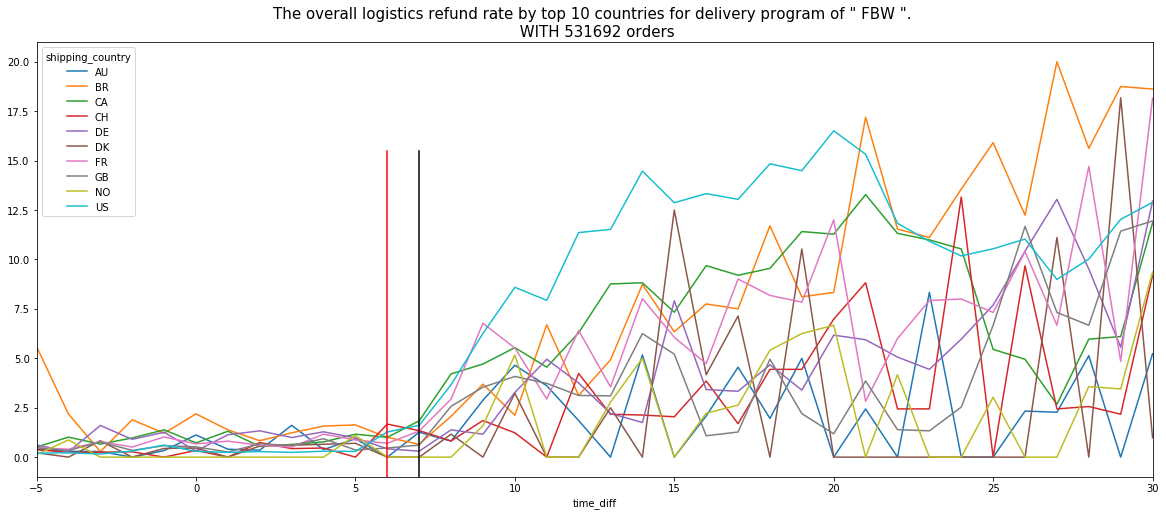

In [144]:
for delivery in delivery_program:
    df_month = df.loc[df.dim_delivery_program==delivery,:].groupby(['shipping_country','time_diff'], as_index=False)['transactions', 'refunds','logistics_refund'].sum()
    df_month.loc[:, 'lrr'] = round(100*df_month.logistics_refund / df_month.transactions,2)
    df_month.loc[:, 'overall_rr'] = round(100*df_month.refunds / df_month.transactions,2)
    pvt = df_month.loc[df_month.shipping_country.isin(countries), :].pivot_table(columns='shipping_country', values='lrr', index='time_diff')
    
    countries = ['US', 'DE', 'GB', 'FR', 'BR', 'AU','CH','NO','CA','DK']
    order_count = sum(df_month.transactions)
    
    plt.figure()
    pvt.plot(figsize=(20,8))
    plt.title('The overall logistics refund rate by top 10 countries for delivery program of " %s ". \n WITH %s orders' %(delivery.upper(),order_count), size = 15)
    plt.axvline(7, 0, 0.75, color='black')
    plt.axvline(6, 0, 0.75, color='red')
    
    plt.show()

## traditional way to look back 180 days TTD

In [146]:
def ttd_180d_query(n):
    query = """
    With TTD as (
    select td_date_trunc('day',unix_timestamp()-{n}*86400,'America/Los_Angeles') as time,
           shipping_country, 
           (COALESCE(delivered, user_confirmed_delivery) - order_time) as actual_TTD_sec
    from sweeper.fact_trans_detail
    where td_time_range(time, td_date_trunc('day',unix_timestamp(),'America/Los_Angeles')-180*86400-{n}*86400,td_date_trunc('day',unix_timestamp()-{n}*86400,'America/Los_Angeles') , 'America/Los_Angeles')
            and ISNOTNULL(shipping_country)
            and ISNOTNULL(order_time)
            and ISNOTNULL(COALESCE(delivered, user_confirmed_delivery))
    )

    insert into table analytics.ttd_180d
    select time as time
          ,TD_TIME_FORMAT(time,'yyyy-MM-dd','America/Los_Angeles') as snap_shot_date
          ,shipping_country
          ,ROUND(actual_TTD_sec_percentile[0]/86400.00,2) as actual_TTD_d_10p
          ,ROUND(actual_TTD_sec_percentile[1]/86400.00,2) as actual_TTD_d_25p
          ,ROUND(actual_TTD_sec_percentile[2]/86400.00,2) as actual_TTD_d_50p
          ,ROUND(actual_TTD_sec_percentile[3]/86400.00,2) as actual_TTD_d_75p
          ,ROUND(actual_TTD_sec_percentile[4]/86400.00,2) as actual_TTD_d_90p
    from(
      select time
             ,shipping_country
             ,PERCENTILE(actual_TTD_sec,ARRAY(0.1,0.25,0.50,0.75,0.90)) as actual_TTD_sec_percentile
      from TTD
      group by 1,2
    ) as temp
    """.format(
      n=n
      )

    return query

In [147]:
ttd_180d_query(1)

"\n    With TTD as (\n    select td_date_trunc('day',unix_timestamp()-1*86400,'America/Los_Angeles') as time,\n           shipping_country, \n           (COALESCE(delivered, user_confirmed_delivery) - order_time) as actual_TTD_sec\n    from sweeper.fact_trans_detail\n    where td_time_range(time, td_date_trunc('day',unix_timestamp(),'America/Los_Angeles')-180*86400-1*86400,td_date_trunc('day',unix_timestamp()-1*86400,'America/Los_Angeles') , 'America/Los_Angeles')\n          and ISNOTNULL(shipping_country)\n    )\n\n    insert into table analytics.ttd_180d\n    select time as time\n          ,TD_TIME_FORMAT(time,'yyyy-MM-dd','America/Los_Angeles') as snap_shot_date\n          ,shipping_country\n          ,ROUND(actual_TTD_sec_percentile[0]/86400.00,2) as actual_TTD_d_10p\n          ,ROUND(actual_TTD_sec_percentile[1]/86400.00,2) as actual_TTD_d_25p\n          ,ROUND(actual_TTD_sec_percentile[2]/86400.00,2) as actual_TTD_d_50p\n          ,ROUND(actual_TTD_sec_percentile[3]/86400.00,2) a

In [181]:
for i in range(11,31):
    dw.td_query(
        query = ttd_180d_query(i),
        # ,job_id=714262814
                    )

You can look at job id 715168793
You can look at job id 715173353
You can look at job id 715176876
You can look at job id 715180339
You can look at job id 715183280
You can look at job id 715185083
You can look at job id 715186644
You can look at job id 715187630
You can look at job id 715188565
You can look at job id 715190256
You can look at job id 715192315
You can look at job id 715193733
You can look at job id 715194744
You can look at job id 715196027
You can look at job id 715197384
You can look at job id 715198107
You can look at job id 715199037
You can look at job id 715199684
You can look at job id 715200459
You can look at job id 715201068


## Jingxiao's quick way to look 180 days TTD

In [421]:
df3 = dw.td_query(
'''
    SELECT
        delivery_date
      , shipping_country
      , origin_country
      , array_agg(ttd ORDER BY ttd) AS ttd
      , array_agg(cnts ORDER BY ttd) AS cnts
      
    FROM (
    SELECT
        td_time_format(COALESCE(confirmed_delivered_time, user_confirmed_delivered_time), 'yyyy-MM-dd') as delivery_date,
        shipping_country,
        origin_country,
        ceil((COAlESCE(confirmed_delivered_time, user_confirmed_delivered_time) - order_time) / 86400)   as ttd,
        
        count(*)  as cnts
        
    FROM fact_trans_detail
    
    WHERE td_time_range(time, '2019-01-01', NULL, 'America/Los_Angeles')
          AND COALESCE(confirmed_delivered_time, user_confirmed_delivered_time) IS NOT NULL
          
    GROUP BY 1,2,3,4
         )
    
    WHERE delivery_date >= '2019-07-01'
    
    GROUP BY 1,2,3
''', engine='presto',
    job_id = 717027932
                          )

You can look at job id 717027932


In [424]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155103 entries, 0 to 155102
Data columns (total 5 columns):
delivery_date       155103 non-null object
shipping_country    155024 non-null object
origin_country      137077 non-null object
ttd                 155103 non-null object
cnts                155103 non-null object
dtypes: object(5)
memory usage: 5.9+ MB


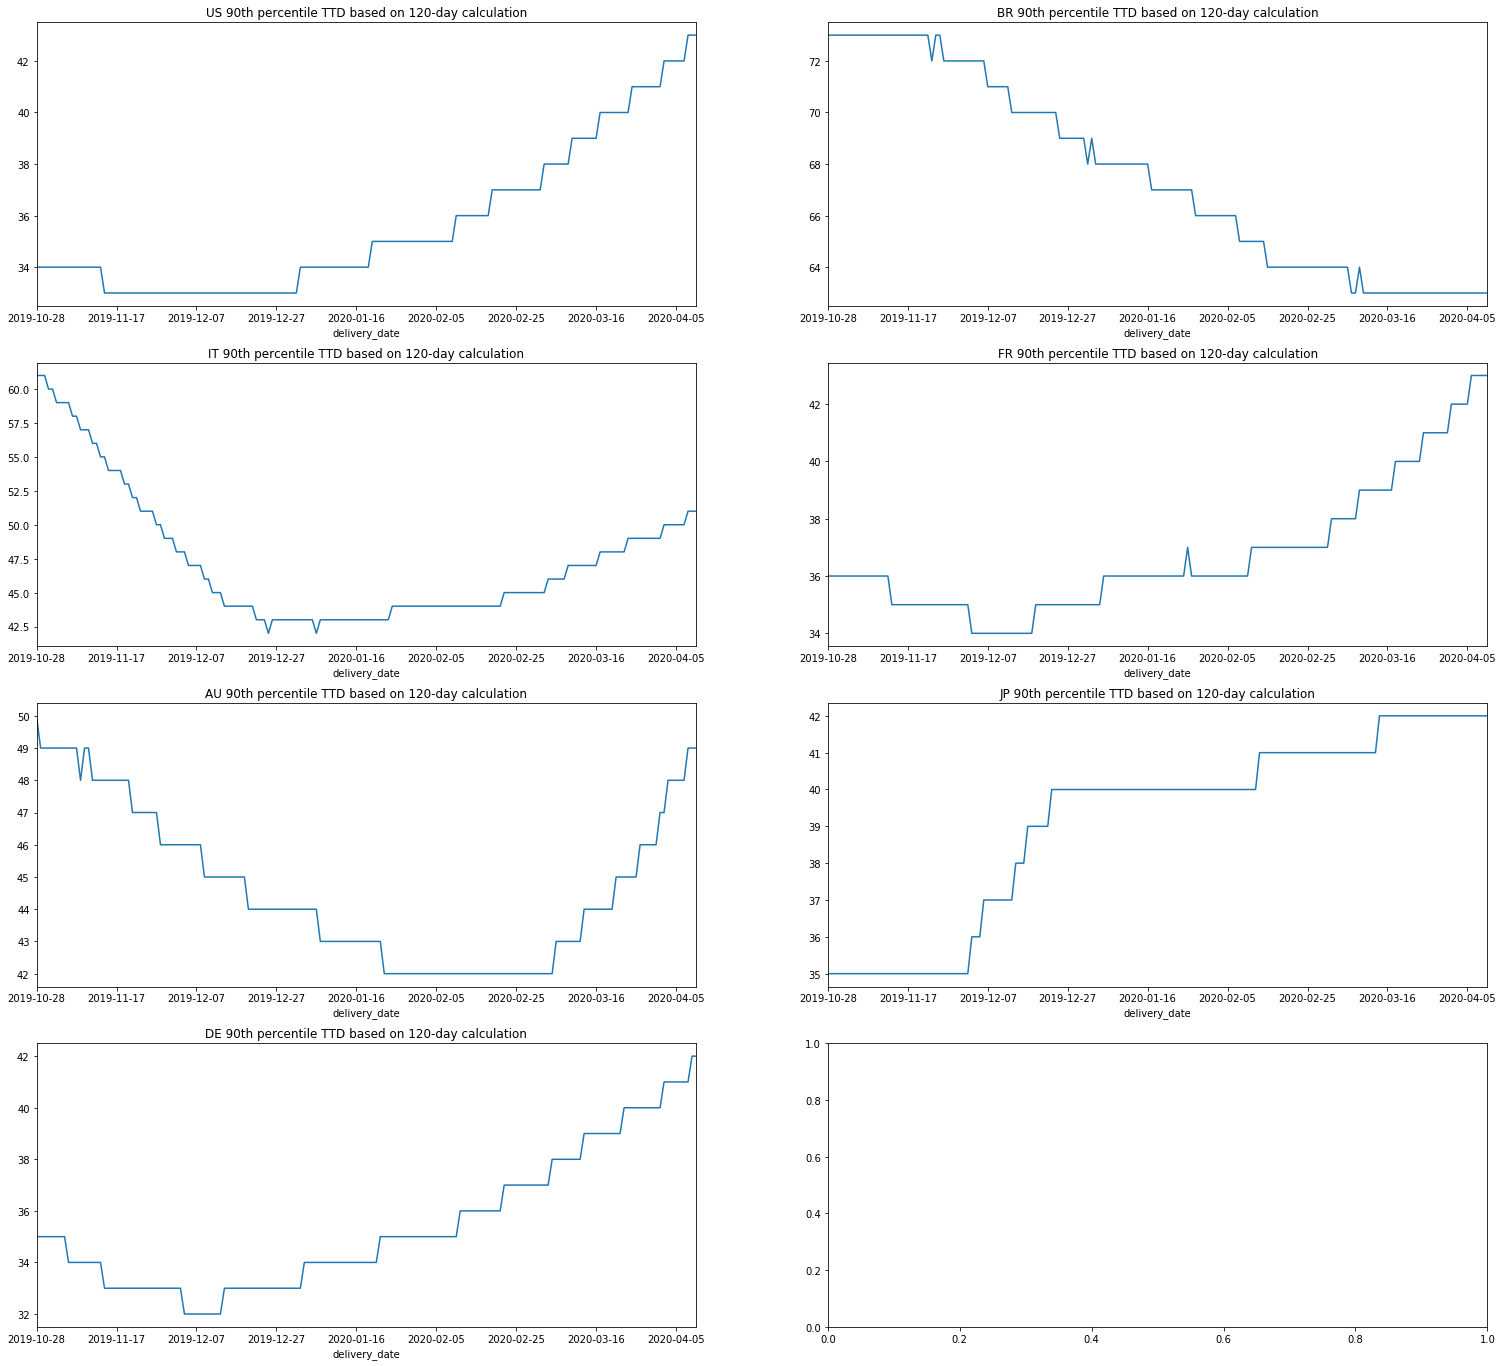

In [434]:
countries = ['US', 'BR', 'IT', 'FR', 'AU', 'JP','DE',]
lookback = 120
m = 2
n = (len(countries)+1) // 2
fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

for t in range(len(countries)):
    c = countries[t]
    this_country = df3.loc[(df3.origin_country=='CN')&(df3.shipping_country==c),:].sort_values('delivery_date').reset_index()
    this_country.loc[:, 'ttd90'] = np.nan
    ttd = pd.Series()
    
    for i in range(lookback):
        ttd = ttd.add(pd.Series(this_country.iloc[i,:].cnts,index=this_country.iloc[i,:].ttd), fill_value=0)
    try:
        for j in range(365):
            ttd90cnt = ttd.sum()*.9
            rollsum = ttd.rolling(100,min_periods=1).sum()
            ttd90 = rollsum[rollsum>ttd90cnt].index[0]
            this_country.loc[j+lookback-1,'ttd90'] = ttd90
            
            ttd = ttd.add(-pd.Series(this_country.iloc[j,:].cnts,index=this_country.iloc[j,:].ttd), fill_value=0) \
                     .add(pd.Series(this_country.iloc[j+lookback,:].cnts,index=this_country.iloc[j+lookback,:].ttd), fill_value=0)
    except:
        pass
    
    x = t//m
    y = t%m
    this_country.loc[~(this_country.ttd90.isna()),:].set_index('delivery_date').ttd90.plot(ax=axes[x][y],title='{} 90th percentile TTD based on {}-day calculation'.format(c, lookback))

In [429]:
this_country.head(180)

index delivery_date shipping_country origin_country  \
0     14066    2019-07-01               DE             CN   
1    125439    2019-07-02               DE             CN   
2     49323    2019-07-03               DE             CN   
3    102446    2019-07-04               DE             CN   
4     59982    2019-07-05               DE             CN   
5    105761    2019-07-06               DE             CN   
6     43843    2019-07-07               DE             CN   
7     61674    2019-07-08               DE             CN   
8     93490    2019-07-09               DE             CN   
9     45584    2019-07-10               DE             CN   
10   130590    2019-07-11               DE             CN   
11    82801    2019-07-12               DE             CN   
12    38709    2019-07-13               DE             CN   
13    86372    2019-07-14               DE             CN   
14    33198    2019-07-15               DE             CN   
15   100273    2019-07-16               DE             CN   
16   142750    2019-07-17               DE             CN   
17   151526    2019-07-18               DE             CN   
18     8935    2019-07-19               DE             CN   
19    21371    2019-07-20               DE             CN   
20    82722    2019-07-21               DE             CN   
21   112653    2019-07-22               DE             CN   
22    45358    2019-07-23               DE             CN   
23    10669    2019-07-24               DE             CN   
24    79075    2019-07-25               DE             CN   
25   140964    2019-07-26               DE             CN   
26    26506    2019-07-27               DE             CN   
27    88095    2019-07-28               DE             CN   
28    19274    2019-07-29               DE             CN   
29   132122    2019-07-30               DE             CN   
..      ...           ...              ...            ...   
150   20997    2019-11-28               DE             CN   
151    5438    2019-11-29               DE             CN   
152  102137    2019-11-30               DE             CN   
153   29893    2019-12-01               DE             CN   
154   91698    2019-12-02               DE             CN   
155   52452    2019-12-03               DE             CN   
156   19278    2019-12-04               DE             CN   
157    1881    2019-12-05               DE             CN   
158  132278    2019-12-06               DE             CN   
159  114560    2019-12-07               DE             CN   
160   61376    2019-12-08               DE             CN   
161    3711    2019-12-09               DE             CN   
162   27999    2019-12-10               DE             CN   
163   23021    2019-12-11               DE             CN   
164   29779    2019-12-12               DE             CN   
165   79564    2019-12-13               DE             CN   
166   89940    2019-12-14               DE             CN   
167   84374    2019-12-15               DE             CN   
168   64925    2019-12-16               DE             CN   
169   63071    2019-12-17               DE             CN   
170    7087    2019-12-18               DE             CN   
171   21225    2019-12-19               DE             CN   
172   88151    2019-12-20               DE             CN   
173   26262    2019-12-21               DE             CN   
174   86178    2019-12-22               DE             CN   
175  121557    2019-12-23               DE             CN   
176  100413    2019-12-24               DE             CN   
177   42303    2019-12-25               DE             CN   
178   50834    2019-12-26               DE             CN   
179   98559    2019-12-27               DE             CN   

                                                   ttd  \
0    [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

## Check the relationship of real TTD and max and min

In [228]:
df = dw.td_query(
'''
    with base as (
    select TD_TIME_FORMAT(order_time,'yyyy-MM-dd','America/Los_Angeles') as order_date
           ,shipping_country
           ,dim_delivery_program
           ,ceil((COAlESCE(delivered, user_confirmed_delivery) - order_time) / 86400) as ttd
           ,max_shipping_time_shown
           ,min_shipping_time_shown

    from analytics.jay_ttd_refund_analysis_2
    where td_time_range(order_time, '2019-09-01', '2020-03-01', 'America/Los_Angeles')
          and (COAlESCE(delivered, user_confirmed_delivery) - order_time) is not null
          and origin_country = 'CN'
          and shipping_country IN ('US')
    )

    select *
           ,if(ttd >= min_shipping_time_shown and ttd <= max_shipping_time_shown,1,0) as within_interval
           ,if(ttd < min_shipping_time_shown,1,0) as lower_than_min
           ,if(ttd > max_shipping_time_shown,1,0) as more_than_max
    from base
''', engine='presto',
#     job_id = 715670159
                          )

You can look at job id 715969395


In [229]:
df.head()

order_date shipping_country dim_delivery_program  ttd  \
0  2019-11-28               US                  EPC   20   
1  2019-11-28               US                  EPC   20   
2  2019-12-29               US             Dropship   17   
3  2019-11-28               US                  EPC   20   
4  2019-11-28               US                  EPC   20   

   max_shipping_time_shown  min_shipping_time_shown  within_interval  \
0                       21                       10                1   
1                       21                       10                1   
2                       25                        8                1   
3                       23                       14                1   
4                       23                       14                1   

   lower_than_min  more_than_max  
0               0              0  
1               0              0  
2               0              0  
3               0              0  
4               0              0

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44577561 entries, 0 to 44577560
Data columns (total 9 columns):
order_date                 object
shipping_country           object
dim_delivery_program       object
ttd                        int64
max_shipping_time_shown    int64
min_shipping_time_shown    int64
within_interval            int64
lower_than_min             int64
more_than_max              int64
dtypes: int64(6), object(3)
memory usage: 3.0+ GB


In [262]:
def q25(x):
    return x.quantile(0.25)
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)
def q90(x):
    return x.quantile(0.9)

In [271]:
df_group = df.groupby(['order_date','shipping_country'],as_index=False).agg(
    {'ttd':['count','mean',q25,q50,q75,q90],
     'max_shipping_time_shown':['mean',q25,q50,q75,q90],
     'min_shipping_time_shown':['mean',q25,q50,q75,q90],
     'within_interval':['sum'],
     'lower_than_min':['sum'],
     'more_than_max':['sum']
    }
)

df_group.columns = ["_".join(x) for x in df_group.columns.ravel()]

In [281]:
df_group['within_interval%'] = round(100*df_group.within_interval_sum/df_group.ttd_count ,2)
df_group['lower_than_min%'] = round(100*df_group.lower_than_min_sum/df_group.ttd_count ,2)
df_group['more_than_max%'] = round(100*df_group.more_than_max_sum/df_group.ttd_count ,2)
df_group.head()

order_date_ shipping_country_  ttd_count   ttd_mean  ttd_q25  ttd_q50  \
0  2019-10-01                US         92  43.369565    27.75     41.5   
1  2019-10-02                US        281  29.177936    23.00     26.0   
2  2019-10-03                US       4228  27.646405    23.00     27.0   
3  2019-10-04                US       4592  26.195557    21.00     25.0   
4  2019-10-05                US     239715  19.924723    16.00     19.0   

   ttd_q75  ttd_q90  max_shipping_time_shown_mean  \
0    64.25       70                     23.782609   
1    32.00       39                     22.875445   
2    30.00       34                     24.251183   
3    30.00       33                     24.283537   
4    23.00       26                     24.118028   

   max_shipping_time_shown_q25  ...  min_shipping_time_shown_q25  \
0                           23  ...                           14   
1                           18  ...                           12   
2                           19  ...                           13   
3                           19  ...                           13   
4                           19  ...                           13   

   min_shipping_time_shown_q50  min_shipping_time_shown_q75  \
0                           23                         23.0   
1                           14                         16.0   
2                           14                         15.0   
3                           14                         15.0   
4                           14                         15.0   

   min_shipping_time_shown_q90  within_interval_sum  lower_than_min_sum  \
0                           23                   24                   0   
1                           23                   94                   0   
2                           16                 1583                  22   
3                           16                 2103                  46   
4                           16               158433               22425   

   more_than_max_sum  within_interval%  lower_than_min%  more_than_max%  
0                 68             26.09             0.00           73.91  
1                187             33.45             0.00           66.55  
2               2623             37.44             0.52           62.04  
3               2443             45.80             1.00           53.20  
4              58857             66.09             9.35           24.55  

[5 rows x 24 columns]

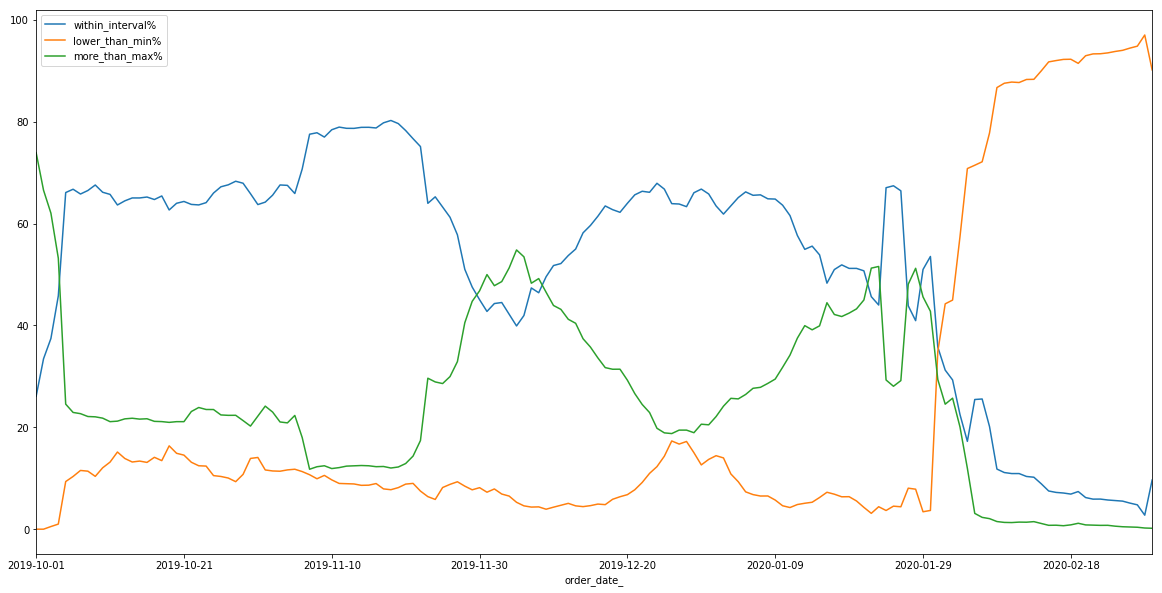

In [286]:
df_group[['order_date_','within_interval%','lower_than_min%','more_than_max%']].set_index('order_date_').plot(figsize=(20, 10))

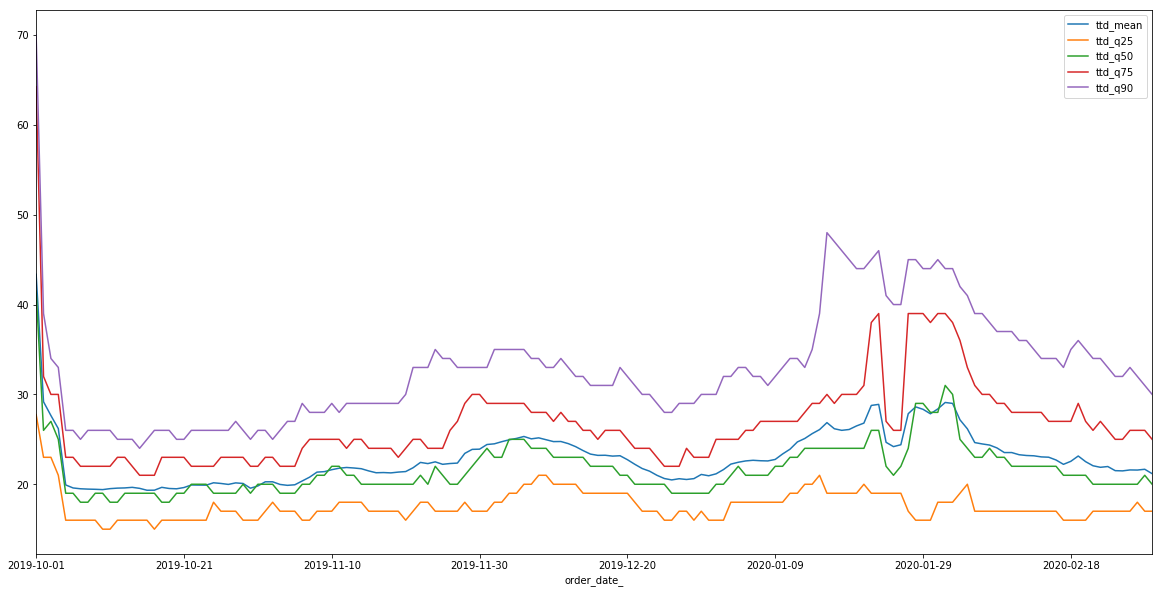

In [289]:
df_group[['order_date_','ttd_mean','ttd_q25','ttd_q50','ttd_q75','ttd_q90']].set_index('order_date_').plot(figsize=(20, 10))

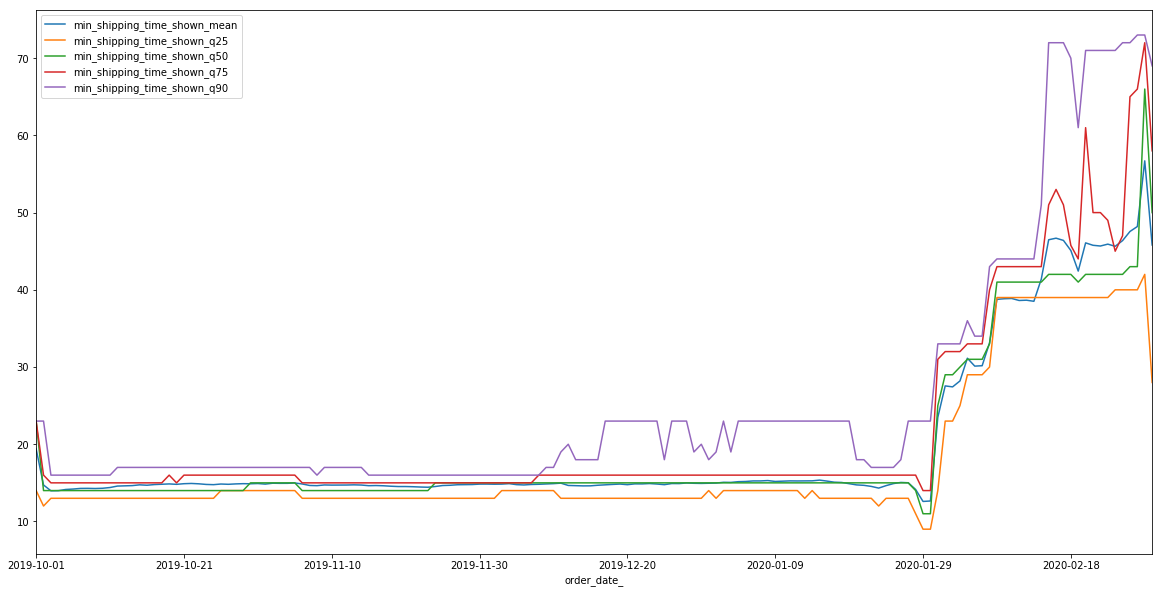

In [290]:
df_group[['order_date_','min_shipping_time_shown_mean','min_shipping_time_shown_q25','min_shipping_time_shown_q50','min_shipping_time_shown_q75','min_shipping_time_shown_q90']].set_index('order_date_').plot(figsize=(20, 10))

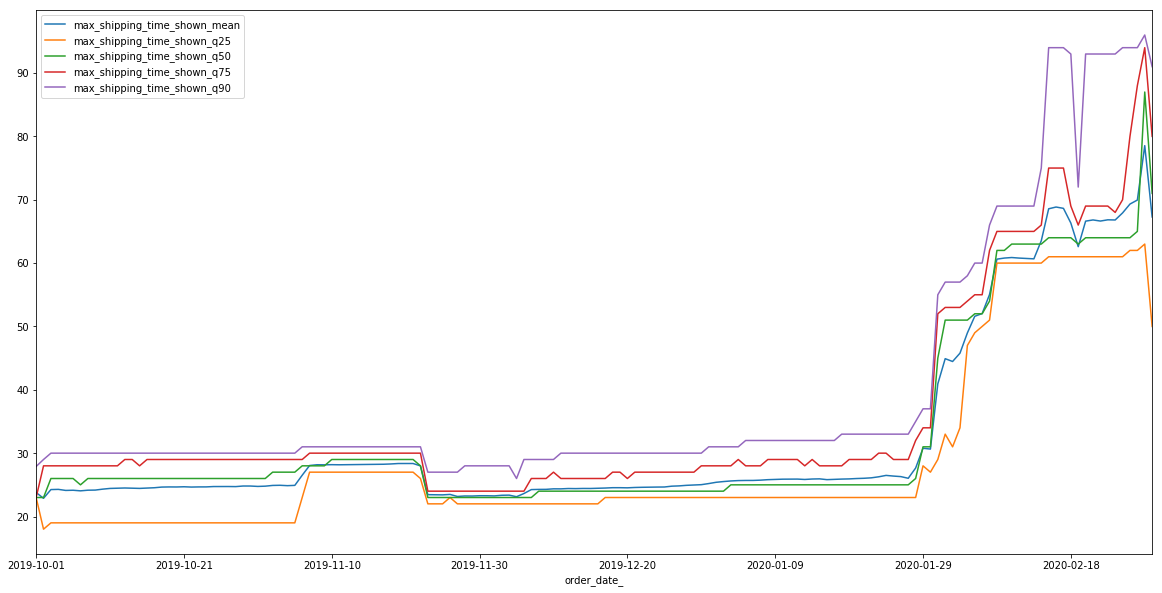

In [291]:
df_group[['order_date_','max_shipping_time_shown_mean','max_shipping_time_shown_q25','max_shipping_time_shown_q50','max_shipping_time_shown_q75','max_shipping_time_shown_q90']].set_index('order_date_').plot(figsize=(20, 10))

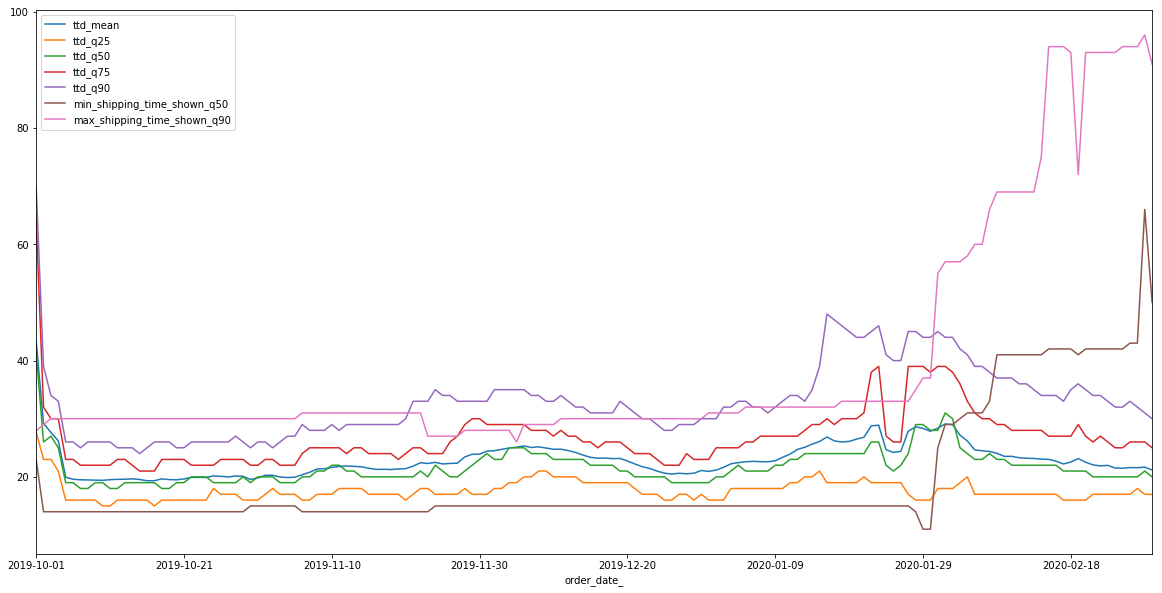

In [310]:
df_group[['order_date_','ttd_mean','ttd_q25','ttd_q50','ttd_q75','ttd_q90','min_shipping_time_shown_q50','max_shipping_time_shown_q90']].set_index('order_date_').plot(figsize=(20, 10))

In [297]:
l = [
    ['order_date_','ttd_mean','min_shipping_time_shown_mean','max_shipping_time_shown_mean'],
    ['order_date_','ttd_q25','min_shipping_time_shown_q25','max_shipping_time_shown_q25'],
    ['order_date_','ttd_q50','min_shipping_time_shown_q50','max_shipping_time_shown_q50'],
    ['order_date_','ttd_q75','min_shipping_time_shown_q75','max_shipping_time_shown_q75'],
    ['order_date_','ttd_q90','min_shipping_time_shown_q90','max_shipping_time_shown_q90']
]
len(l)

5

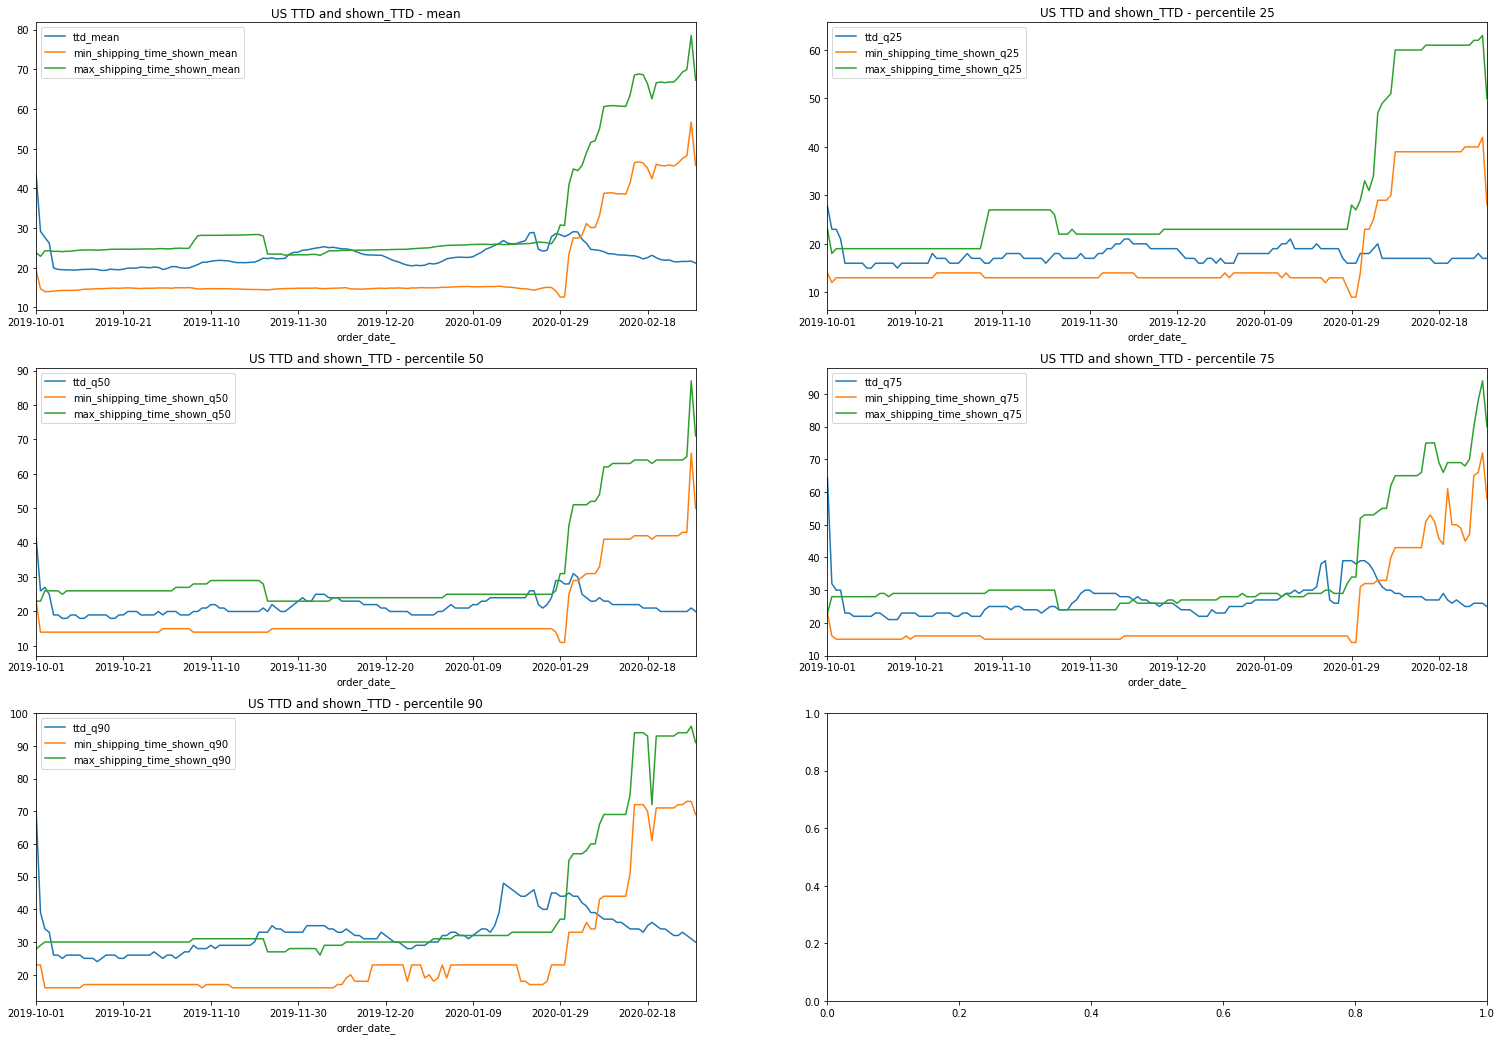

In [307]:
m = 2
n = (len(l)+1) // 2
fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))
name = ['mean','percentile 25','percentile 50','percentile 75','percentile 90']

for i in range(len(l)):
#     print(df_group[l[i]].head())
#     df_group[l[i]].plot(figsize=(15, 8))
    x = i//m
    y = i%m
    df_group[l[i]].set_index('order_date_').plot(ax=axes[x][y],title='US TTD and shown_TTD - {}'.format(name[i]))

## latest update @2020-04-10

In [567]:
df = dw.td_query(
'''
''', engine='presto',
    job_id = 717276501
                          )

You can look at job id 717276501


In [568]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21392 entries, 0 to 21391
Data columns (total 27 columns):
order_date                          21392 non-null object
shipping_country                    21392 non-null object
total_orders                        21392 non-null int64
total_orders_with_delivery_info     21392 non-null int64
order_w_delivery_info_percentage    21392 non-null float64
within_interval_orders              21392 non-null int64
lower_than_min_orders               21392 non-null int64
more_than_max_orders                21392 non-null int64
within_interval_orders_perc         18088 non-null float64
lower_than_min_orders_perc          18088 non-null float64
more_than_max_orders_perc           18088 non-null float64
actual_ttd_avg                      18088 non-null float64
actual_ttd_25p                      18088 non-null float64
actual_ttd_50p                      18088 non-null float64
actual_ttd_90p                      18088 non-null float64
shown_ttd_min_wo_p

In [525]:
df3 = dw.td_query(
'''
    SELECT
        delivery_date
      , shipping_country
      , origin_country
      , array_agg(ttd ORDER BY ttd) AS ttd
      , array_agg(cnts ORDER BY ttd) AS cnts
      
    FROM (
    SELECT
        td_time_format(COALESCE(confirmed_delivered_time, user_confirmed_delivered_time), 'yyyy-MM-dd') as delivery_date,
        shipping_country,
        origin_country,
        ceil((COAlESCE(confirmed_delivered_time, user_confirmed_delivered_time) - order_time) / 86400)   as ttd,
        
        count(*)  as cnts
        
    FROM fact_trans_detail
    
    WHERE td_time_range(time, '2019-01-01', NULL, 'America/Los_Angeles')
          AND COALESCE(confirmed_delivered_time, user_confirmed_delivered_time) IS NOT NULL
          
    GROUP BY 1,2,3,4
         )
    
    WHERE delivery_date >= '2019-04-01'
    
    GROUP BY 1,2,3
''', engine='presto',
#     job_id = 717027932
                          )

You can look at job id 717192453


In [528]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197910 entries, 0 to 197909
Data columns (total 5 columns):
delivery_date       197910 non-null object
shipping_country    197796 non-null object
origin_country      174841 non-null object
ttd                 197910 non-null object
cnts                197910 non-null object
dtypes: object(5)
memory usage: 7.5+ MB


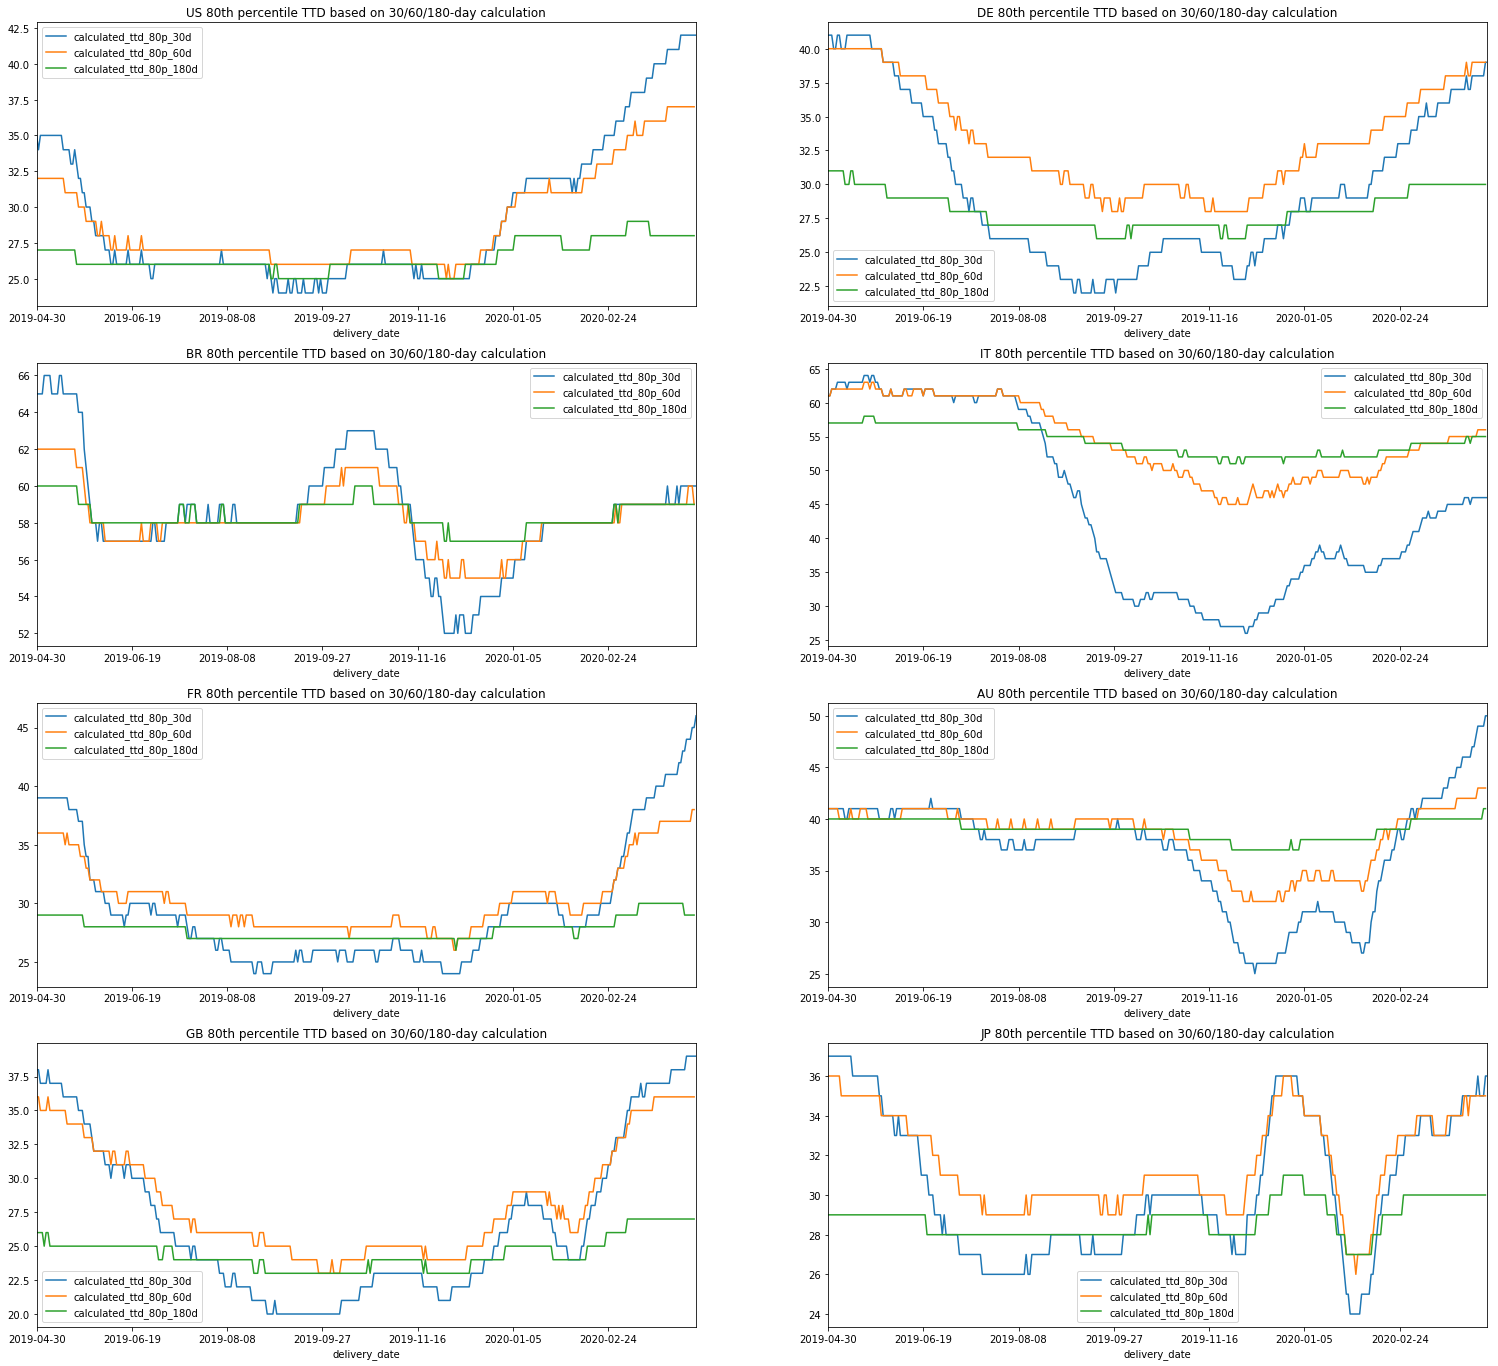

In [547]:
countries = ['US','DE','BR', 'IT', 'FR', 'AU', 'GB','JP']
lookback = 30
lookback_60 = 60
lookback_180 = 180

m = 2
n = (len(countries)+1) // 2
fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

cut_off = '2020-04-01'

df4 = pd.DataFrame()

metrics = ['calculated_ttd_80p_30d','calculated_ttd_80p_60d','calculated_ttd_80p_180d']

for t in range(len(countries)):
    c = countries[t]
    this_country = df3.loc[(df3.origin_country=='CN')&(df3.shipping_country==c),:].sort_values('delivery_date').reset_index()
    this_country.loc[:, 'calculated_ttd_80p_30d'] = np.nan
    this_country.loc[:, 'calculated_ttd_80p_60d'] = np.nan
    this_country.loc[:, 'calculated_ttd_80p_180d'] = np.nan
#     this_country.loc[:, 'ttd50p_180d'] = np.nan
#     this_country.loc[:, 'ttd50p_60d'] = np.nan
#     this_country.loc[:, 'ttd50p_30d'] = np.nan
    
    ttd = pd.Series()
    ttd_60d = pd.Series()
    ttd_180d = pd.Series()
    
    for i in range(lookback):
        ttd = ttd.add(pd.Series(this_country.iloc[i,:].cnts,index=this_country.iloc[i,:].ttd), fill_value=0)
    for i in range(lookback_60):
        ttd_60d = ttd_60d.add(pd.Series(this_country.iloc[i,:].cnts,index=this_country.iloc[i,:].ttd), fill_value=0)
    for i in range(lookback_180):
        ttd_180d = ttd_180d.add(pd.Series(this_country.iloc[i,:].cnts,index=this_country.iloc[i,:].ttd), fill_value=0)

    try:
        for j in range(365):
            ttd95cnt = ttd.sum()*.95
            rollsum = ttd.rolling(500,min_periods=1).sum()
            ttd95 = rollsum[rollsum>ttd95cnt].index[0]
            ttd80cnt = ttd.sum()*.80
            ttd80 = rollsum[rollsum>ttd80cnt].index[0]
            
#             if this_country.loc[j+lookback-1,'delivery_date']>=cut_off:
#                 this_country.loc[j+lookback-1,'calculated_ttd_80p_30d'] = ttd95
#             elif this_country.loc[j+lookback-1,'delivery_date']<cut_off:
            this_country.loc[j+lookback-1,'calculated_ttd_80p_30d'] = ttd80
            
            ttd = ttd.add(-pd.Series(this_country.iloc[j,:].cnts,index=this_country.iloc[j,:].ttd), fill_value=0) \
                     .add(pd.Series(this_country.iloc[j+lookback,:].cnts,index=this_country.iloc[j+lookback,:].ttd), fill_value=0)
            
            
            ttd95cnt_60d = ttd_60d.sum()*.95
            rollsum_60d = ttd_60d.rolling(500,min_periods=1).sum()
            ttd95_60d = rollsum_60d[rollsum_60d>ttd95cnt_60d].index[0]
            ttd80cnt_60d = ttd_60d.sum()*.80
            ttd80_60d = rollsum_60d[rollsum_60d>ttd80cnt_60d].index[0]
            
#             if this_country.loc[j+lookback-1,'delivery_date']>=cut_off:
#                 this_country.loc[j+lookback-1,'calculated_ttd_80p_60d'] = ttd95_60d
#             elif this_country.loc[j+lookback-1,'delivery_date']<cut_off:
            this_country.loc[j+lookback-1,'calculated_ttd_80p_60d'] = ttd80_60d            
            
            ttd_60d = ttd_60d.add(-pd.Series(this_country.iloc[j,:].cnts,index=this_country.iloc[j,:].ttd), fill_value=0) \
                     .add(pd.Series(this_country.iloc[j+lookback,:].cnts,index=this_country.iloc[j+lookback,:].ttd), fill_value=0)
            
            
            ttd95cnt_180d = ttd_180d.sum()*.95
            rollsum_180d = ttd_180d.rolling(500,min_periods=1).sum()
            ttd95_180d = rollsum_180d[rollsum_180d>ttd95cnt_180d].index[0]
            ttd80cnt_180d = ttd_180d.sum()*.80
            ttd80_180d = rollsum_180d[rollsum_180d>ttd80cnt_180d].index[0]
            
#             if this_country.loc[j+lookback-1,'delivery_date']>=cut_off:
#                 this_country.loc[j+lookback-1,'calculated_ttd_80p_180d'] = ttd95_180d
#             elif this_country.loc[j+lookback-1,'delivery_date']<cut_off:
            this_country.loc[j+lookback-1,'calculated_ttd_80p_180d'] = ttd80_180d            
            
            ttd_180d = ttd_180d.add(-pd.Series(this_country.iloc[j,:].cnts,index=this_country.iloc[j,:].ttd), fill_value=0) \
                     .add(pd.Series(this_country.iloc[j+lookback,:].cnts,index=this_country.iloc[j+lookback,:].ttd), fill_value=0)
            
    except:
        pass
    
    df4 = df4.append(this_country,ignore_index=True)
    
    x = t//m
    y = t%m
    this_country.loc[~(this_country.calculated_ttd_80p_30d.isna()),:].set_index('delivery_date')[metrics].plot(ax=axes[x][y],title='{} 80th percentile TTD based on 30/60/180-day calculation'.format(c, lookback))

In [569]:
df5= df.merge(df4[['delivery_date','shipping_country','calculated_ttd_80p_60d','calculated_ttd_80p_180d']], how='left',left_on=['order_date','shipping_country'],\
              right_on=['delivery_date','shipping_country'])

In [475]:
programs = list(set(df.dim_delivery_program))
programs

['A+', 'Wish_Express', 'EPC', 'Dropship', 'Fusion', 'FBW']

In [570]:
df.head(10)

order_date shipping_country  total_orders  total_orders_with_delivery_info  \
0  2019-10-01               GB             1                                1   
1  2019-10-02               CZ           100                               22   
2  2019-10-02               NG            25                                8   
3  2019-10-03               CR           486                               57   
4  2019-10-03               KW             2                                0   
5  2019-10-04               AZ            16                                3   
6  2019-10-04               BR         24359                             7229   
7  2019-10-04               FI             1                                0   
8  2019-10-04               MV             2                                0   
9  2019-10-05               AR          4748                              896   

   order_w_delivery_info_percentage  within_interval_orders  \
0                            100.00                       1   
1                             22.00                      12   
2                             32.00                       1   
3                             11.73                      23   
4                              0.00                       0   
5                             18.75                       1   
6                             29.68                    4534   
7                              0.00                       0   
8                              0.00                       0   
9                             18.87                     460   

   lower_than_min_orders  more_than_max_orders  within_interval_orders_perc  \
0                      0                     0                       100.00   
1                      0                    10                        54.55   
2                      3                     4                        12.50   
3                      1                    33                        40.35   
4                      0                     0                          NaN   
5                      0                     2                        33.33   
6                    462                  2233                        62.72   
7                      0                     0                          NaN   
8                      0                     0                          NaN   
9                    125                   311                        51.34   

   lower_than_min_orders_perc  ...  shown_ttd_min_wo_padding_50p  \
0                        0.00  ...                           9.0   
1                        0.00  ...                          15.0   
2                       37.50  ...                          18.0   
3                        1.75  ...                          28.0   
4                         NaN  ...                          21.0   
5                        0.00  ...                          18.0   
6                        6.39  ...                          26.0   
7                         NaN  ...                          19.0   
8                         NaN  ...                          12.0   
9                       13.95  ...                          37.0   

   shown_ttd_min_wo_padding_90p  shown_ttd_max_wo_padding_avg  \
0                           9.0                     23.000000   
1                          18.0                     30.390000   
2                          18.0                     29.040000   
3                          32.0                     48.119342   
4                          21.8                     50.000000   
5                          25.0                     42.625000   
6                          31.0                     49.259822   
7                          19.0                     45.000000   
8                          12.0                     32.000000   
9                          43.0                     58.283909   

   shown_ttd_max_wo_padding_25p  shown_ttd_max_wo_padding_50p  \
0                

In [571]:
# df_chart = df.loc[(df.shipping_country=='US') & (df.dim_delivery_program.isin(['A+','EPC','Dropship'])),:].groupby(['order_date','shipping_country'],as_index=False)['total_orders', 'total_orders_with_delivery_info'].sum()
# df_chart['order_w_delivery_info_percentage'] = round(100*df_chart.total_orders_with_delivery_info/df_chart.total_orders,2)
# df_chart.head()

In [574]:
def chart_delivery_coverage(country='US'):
    country = country
#     m = 2
#     n = (len(programs)+1) // 2
#     fig, axes = plt.subplots(n, m, figsize=(30, 20))

#     for i in range(len(programs)):
#         x = i//m
#         y = i%m
    #     df_group[l[i]].set_index('order_date_').plot(ax=axes[x][y],title='US TTD and shown_TTD - {}'.format(name[i])) order_w_delivery_info_percentage
    df_chart = df.loc[(df.shipping_country==country),:].groupby(['order_date','shipping_country'],as_index=False)['total_orders', 'total_orders_with_delivery_info'].sum()
#     df_chart = df.loc[(df.shipping_country==country) & (df.dim_delivery_program.isin(['A+','EPC','Dropship'])),:].groupby(['order_date','shipping_country'],as_index=False)['total_orders', 'total_orders_with_delivery_info'].sum()
    df_chart['order_w_delivery_info_percentage'] = round(100*df_chart.total_orders_with_delivery_info/df_chart.total_orders,2)
    try: 
#         df.loc[(df.shipping_country==country) & (df.dim_delivery_program== programs[i]),['order_date','order_w_delivery_info_percentage']].sort_values('order_date').set_index('order_date').\
#         plot(ax=axes[x][y],title='{} % of orders which have delivery info, for {} program'.format(country,programs[i]))
        fig = plt.figure()
        df_chart[['order_date','order_w_delivery_info_percentage']].sort_values('order_date').set_index('order_date')\
        .plot(figsize=(20,10),title='{} % of orders which have delivery info, for orders shipped from China'.format(country))
        plt.savefig('delivery_coverage_{}.png'.format(country))
    except:
        pass

<Figure size 432x288 with 0 Axes>

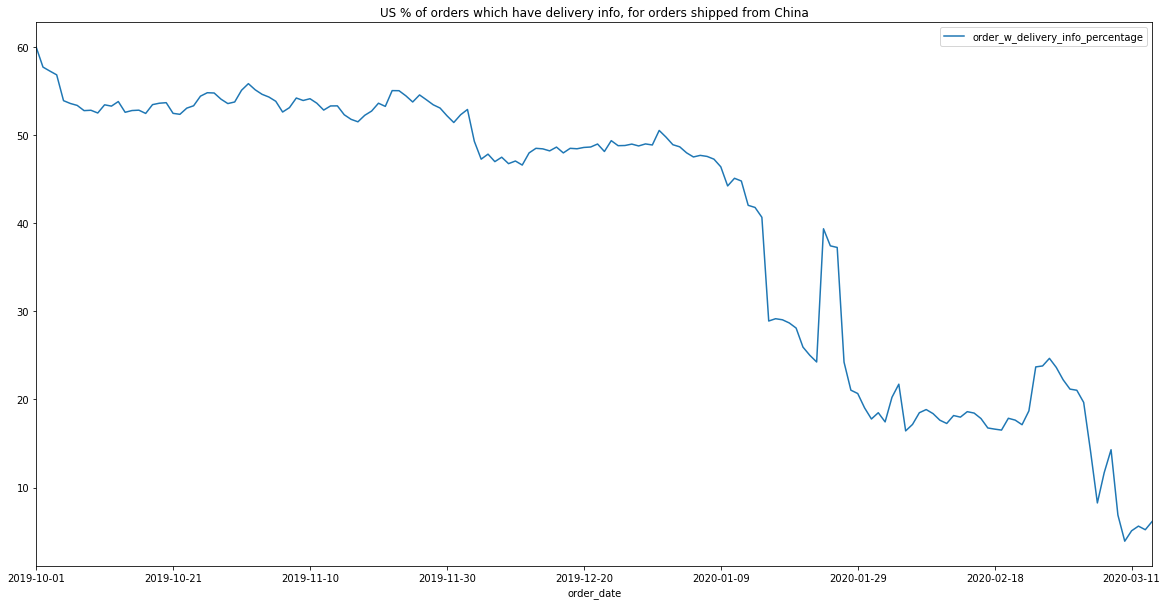

<Figure size 432x288 with 0 Axes>

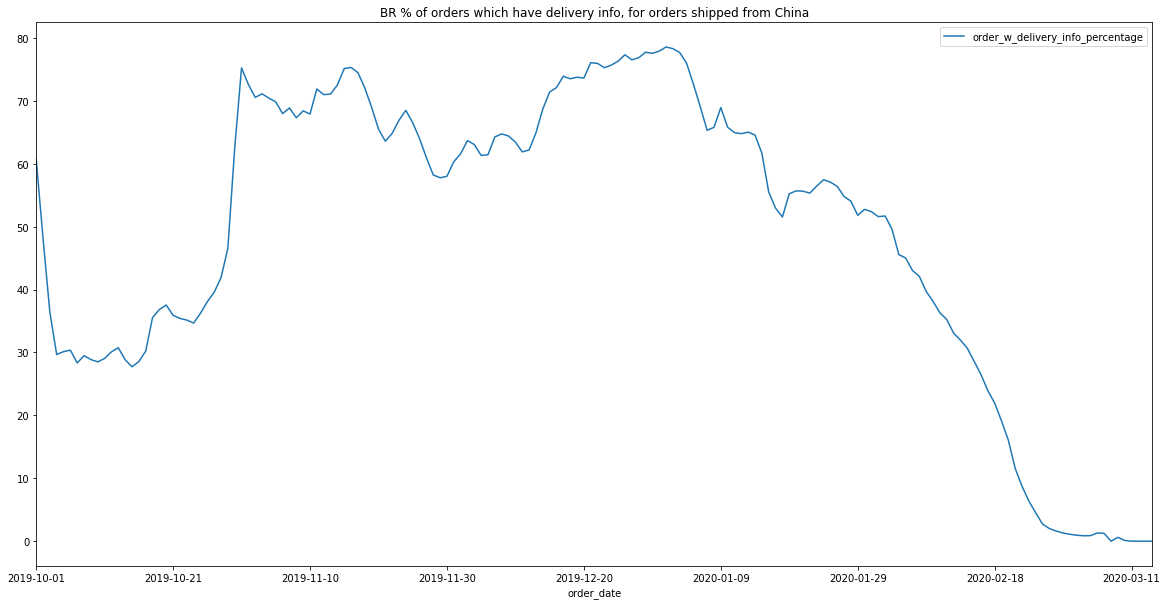

<Figure size 432x288 with 0 Axes>

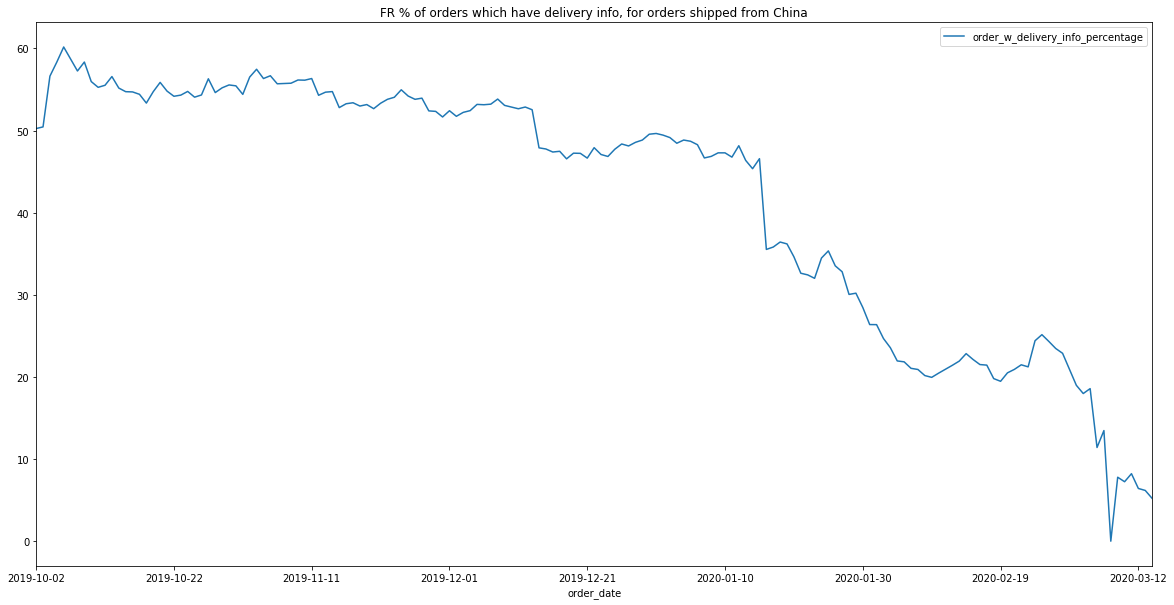

<Figure size 432x288 with 0 Axes>

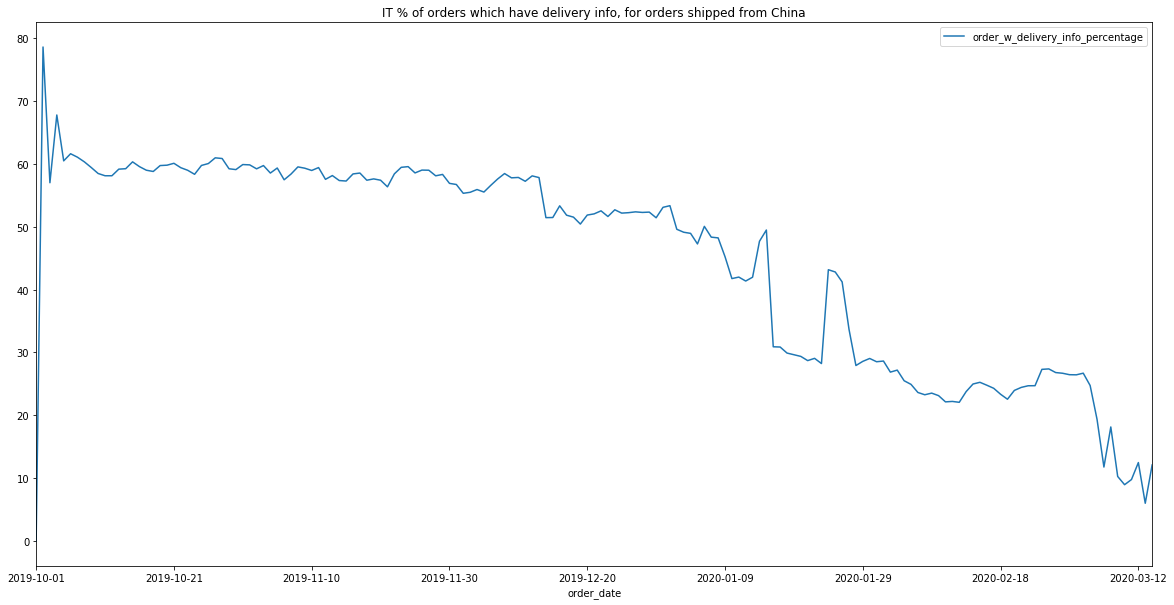

In [575]:
countries = ['US','BR','FR','IT']
for c in countries:
    chart_delivery_coverage(c)    

In [521]:
def chart_actual_shown_TTD_relationship(country='US'):
    country = country
    metrics = ['order_date','within_interval_orders_perc','lower_than_min_orders_perc','more_than_max_orders_perc']
    m = 2
    n = (len(programs)+1) // 2
    fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

    for i in range(len(programs)):
        x = i//m
        y = i%m
    #     df_group[l[i]].set_index('order_date_').plot(ax=axes[x][y],title='US TTD and shown_TTD - {}'.format(name[i]))
        try: 
            df.loc[(df.shipping_country==country) & (df.dim_delivery_program== programs[i]),metrics]\
            .sort_values('order_date').set_index('order_date').plot(ax=axes[x][y],title='{} actuall TTD distribution in terms of shown TTD w/o padding, for {} program'.format(country,programs[i]))
        except:
            pass

In [577]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21392 entries, 0 to 21391
Data columns (total 30 columns):
order_date                          21392 non-null object
shipping_country                    21392 non-null object
total_orders                        21392 non-null int64
total_orders_with_delivery_info     21392 non-null int64
order_w_delivery_info_percentage    21392 non-null float64
within_interval_orders              21392 non-null int64
lower_than_min_orders               21392 non-null int64
more_than_max_orders                21392 non-null int64
within_interval_orders_perc         18088 non-null float64
lower_than_min_orders_perc          18088 non-null float64
more_than_max_orders_perc           18088 non-null float64
actual_ttd_avg                      18088 non-null float64
actual_ttd_25p                      18088 non-null float64
actual_ttd_50p                      18088 non-null float64
actual_ttd_90p                      18088 non-null float64
shown_ttd_min_wo_p

In [580]:
def chart_actual_shown_TTD_trend_over_time(country='US'):
    country = country
    metrics = ['order_date','actual_ttd_50p','shown_ttd_min_wo_padding_avg','shown_ttd_max_wo_padding_avg','ttd_delta_maxshown_actuall_avg','calculated_ttd_80p_60d','calculated_ttd_80p_180d']

#     m = 2
#     n = (len(programs)+1) // 2
#     fig, axes = plt.subplots(n, m, figsize=(m*13, n*6))

#     for i in range(len(programs)):
#         x = i//m
#         y = i%m
    try: 
        fig = plt.figure()
        df5.loc[(df5.shipping_country==country),metrics].sort_values('order_date').\
        set_index('order_date').plot(figsize=(20,10),title='{} actual and shown TTD trending'.format(country))
        plt.savefig('shown_and_actual_TTD_trending_{}.png'.format(country))
    except:
        pass

<Figure size 432x288 with 0 Axes>

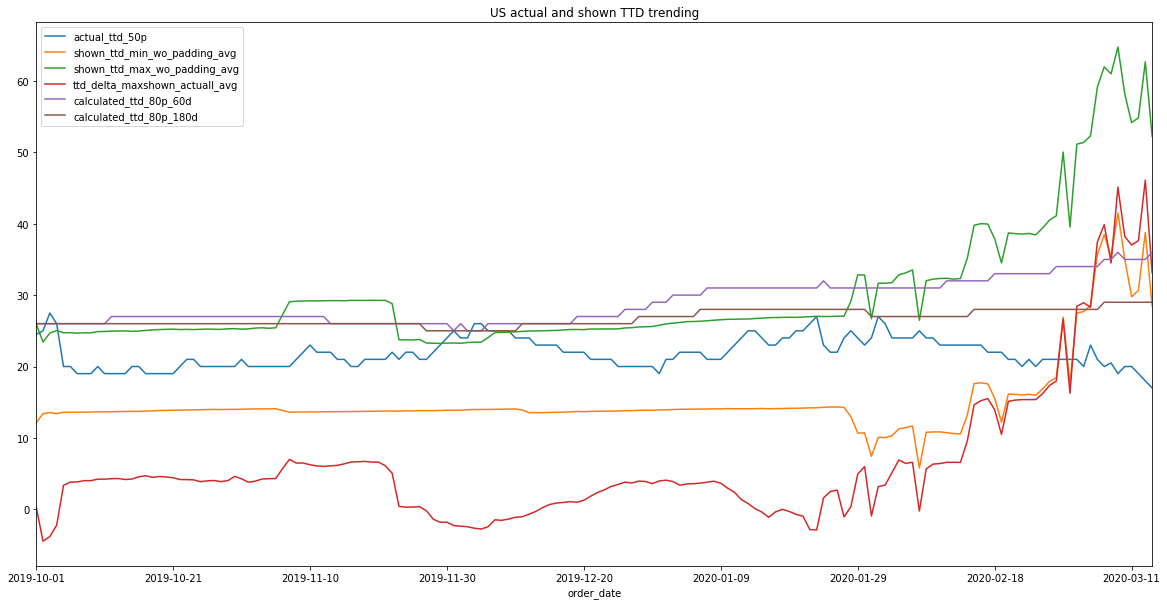

<Figure size 432x288 with 0 Axes>

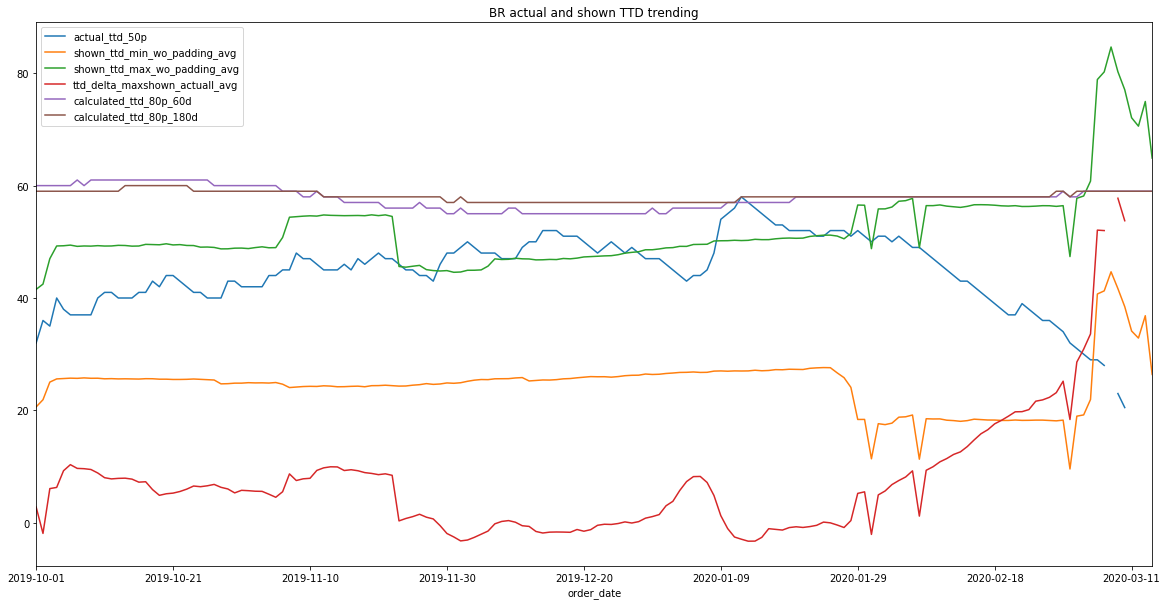

<Figure size 432x288 with 0 Axes>

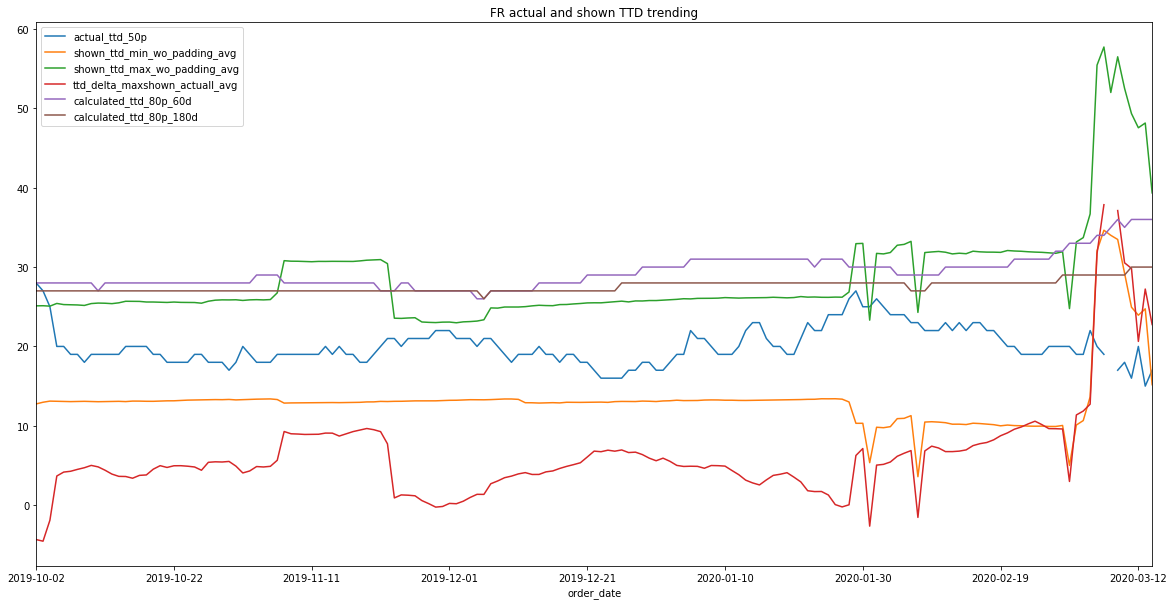

<Figure size 432x288 with 0 Axes>

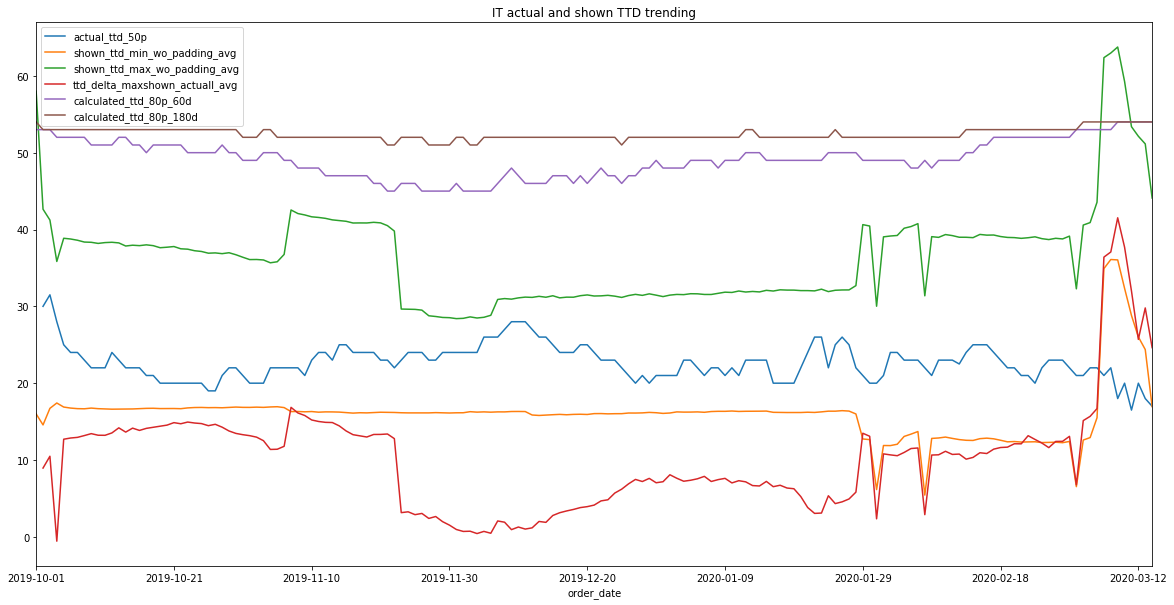

In [581]:
countries = ['US','BR','FR','IT']
for c in countries:
    chart_actual_shown_TTD_trend_over_time(c)

### USA

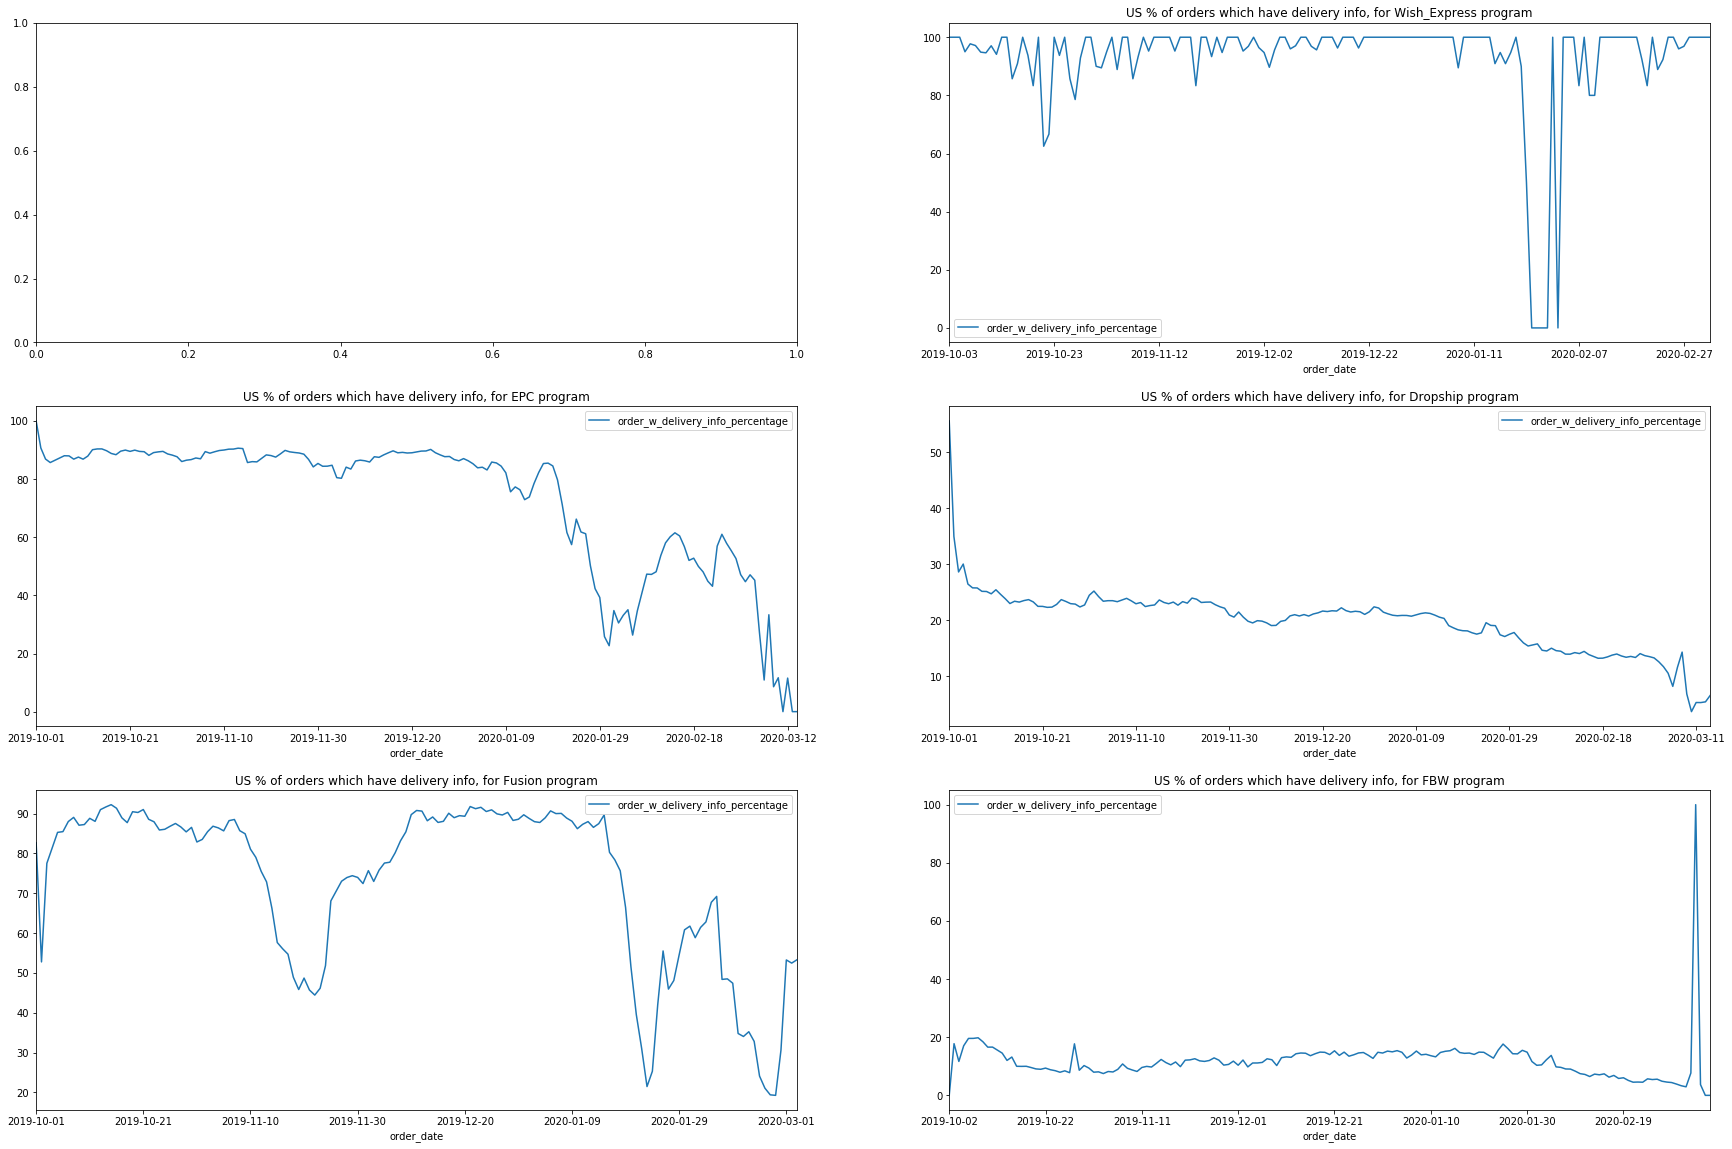

In [505]:
chart_delivery_coverage('US')

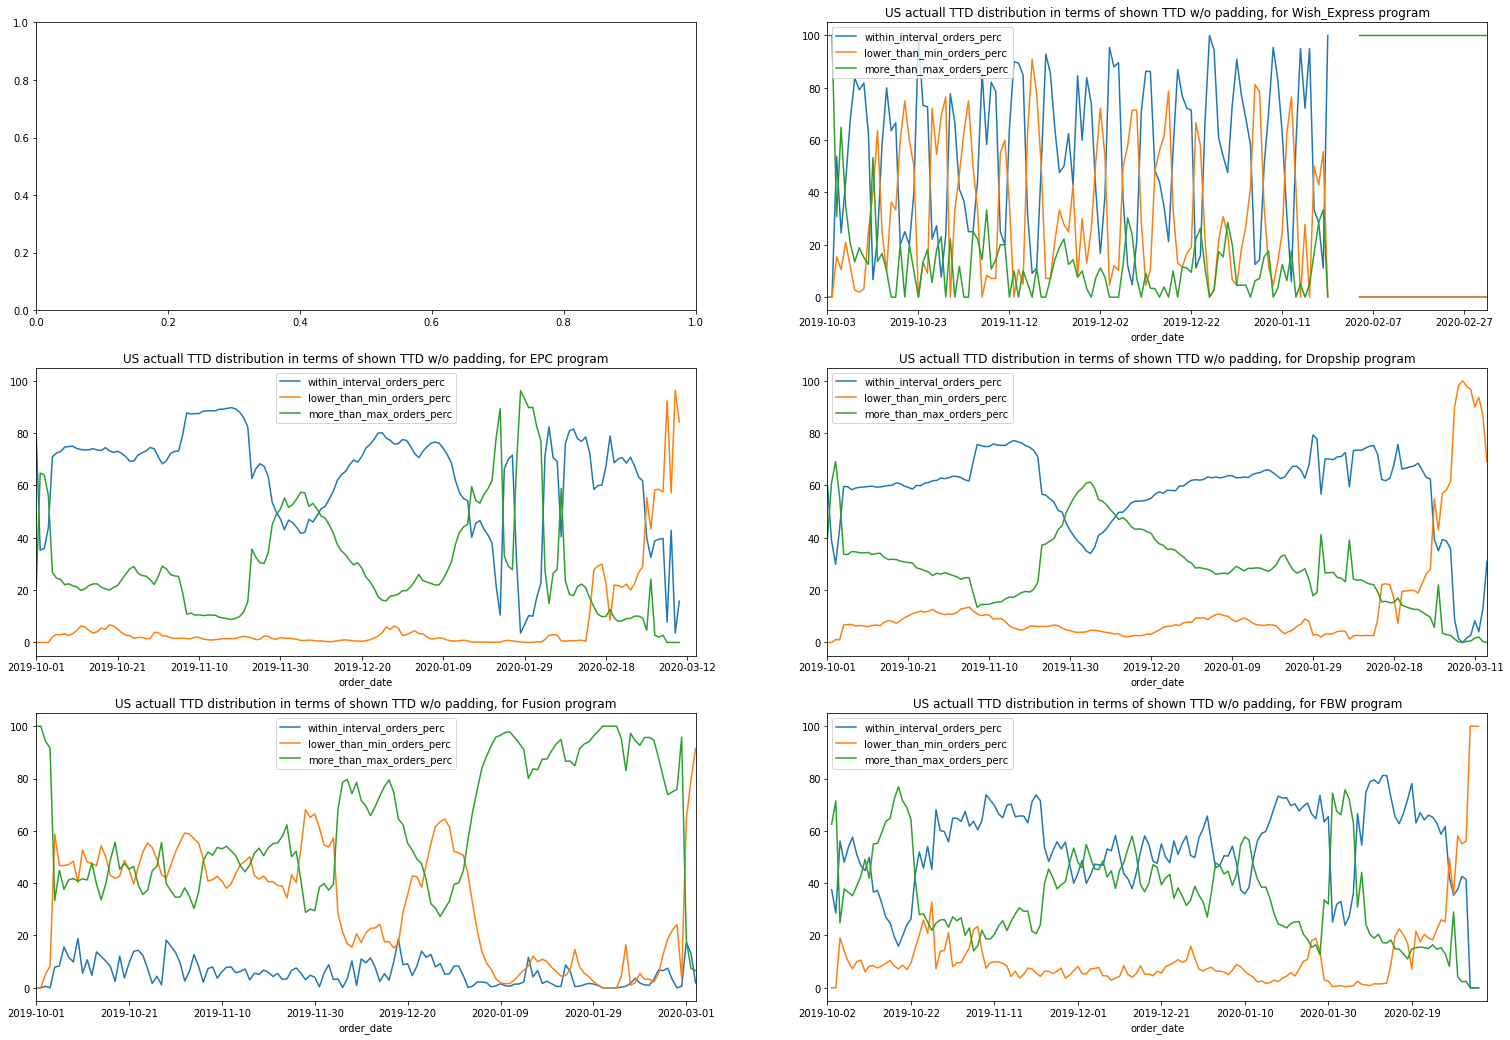

In [509]:
chart_actual_shown_TTD_relationship('US')

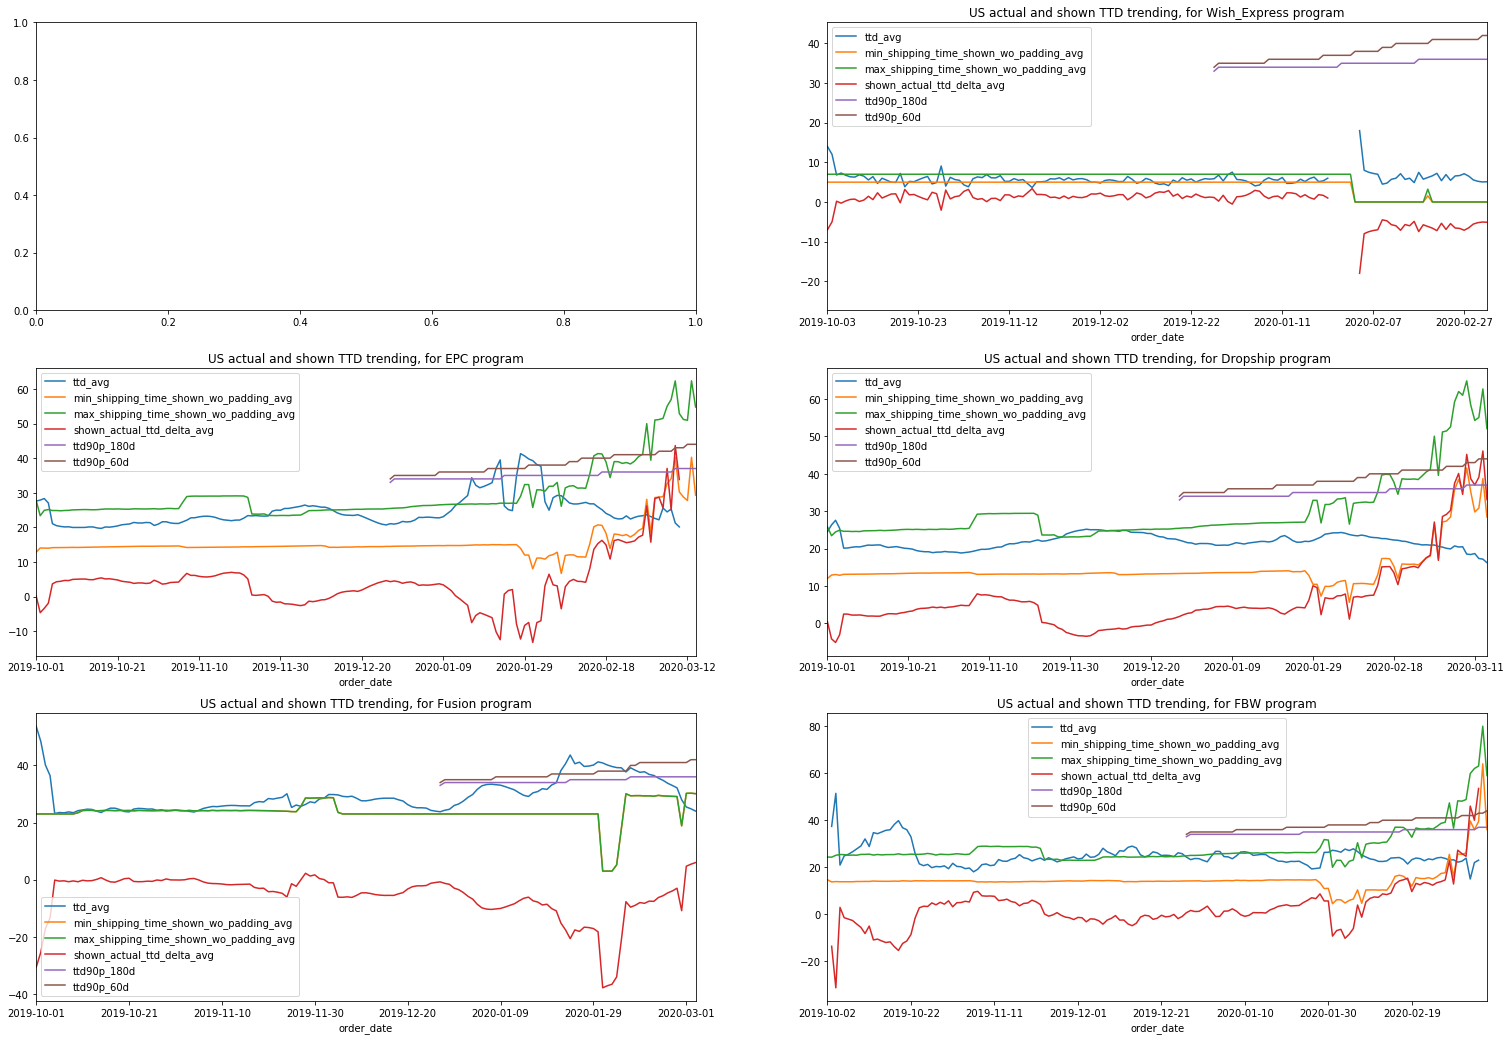

In [516]:
chart_actual_shown_TTD_trend_over_time()

### Brazil

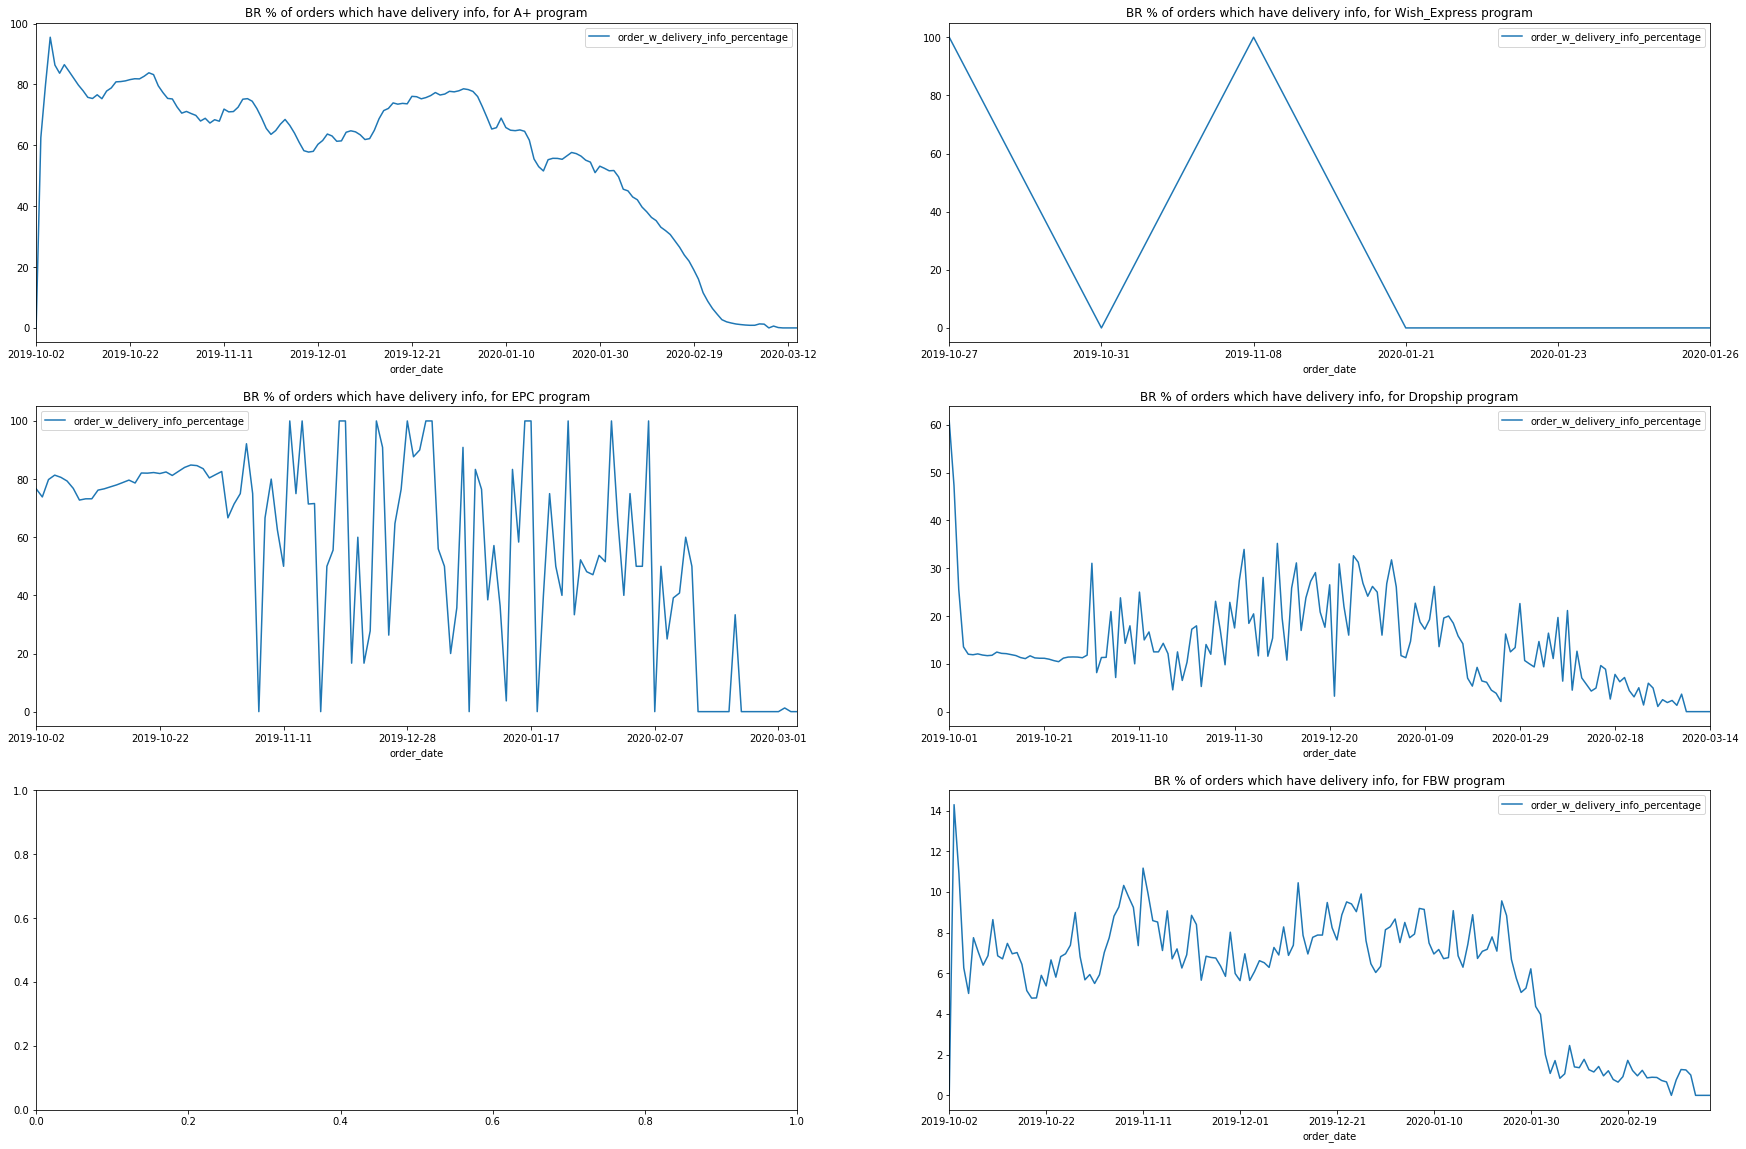

In [506]:
chart_delivery_coverage('BR')

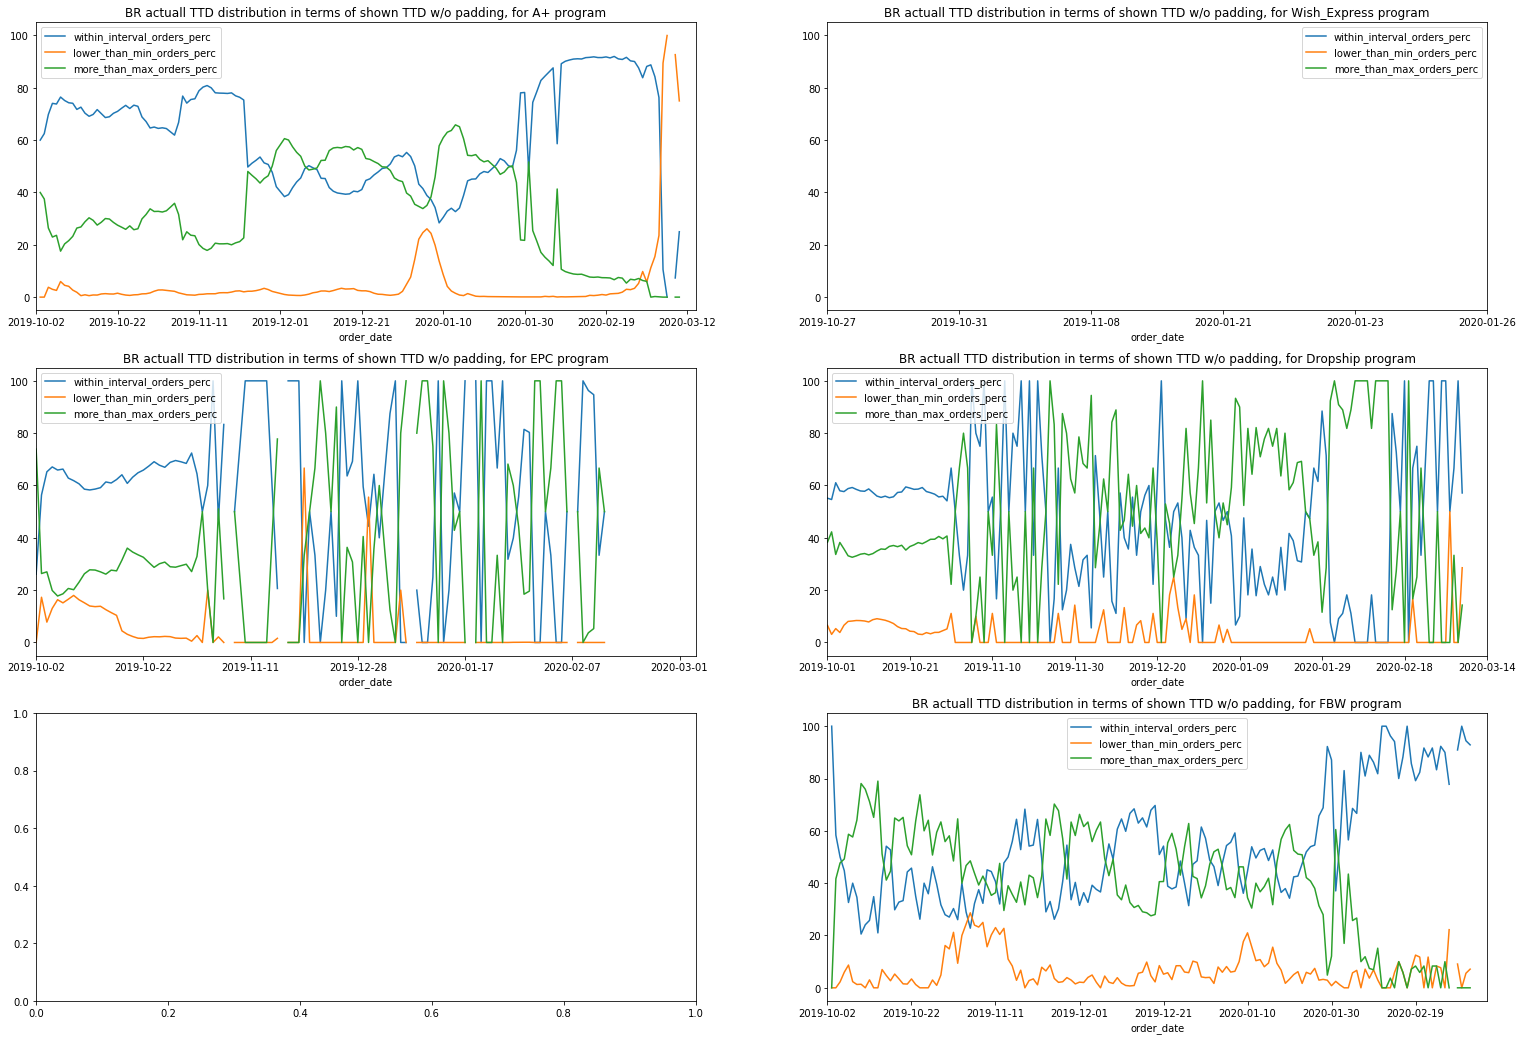

In [510]:
chart_actual_shown_TTD_relationship('BR')

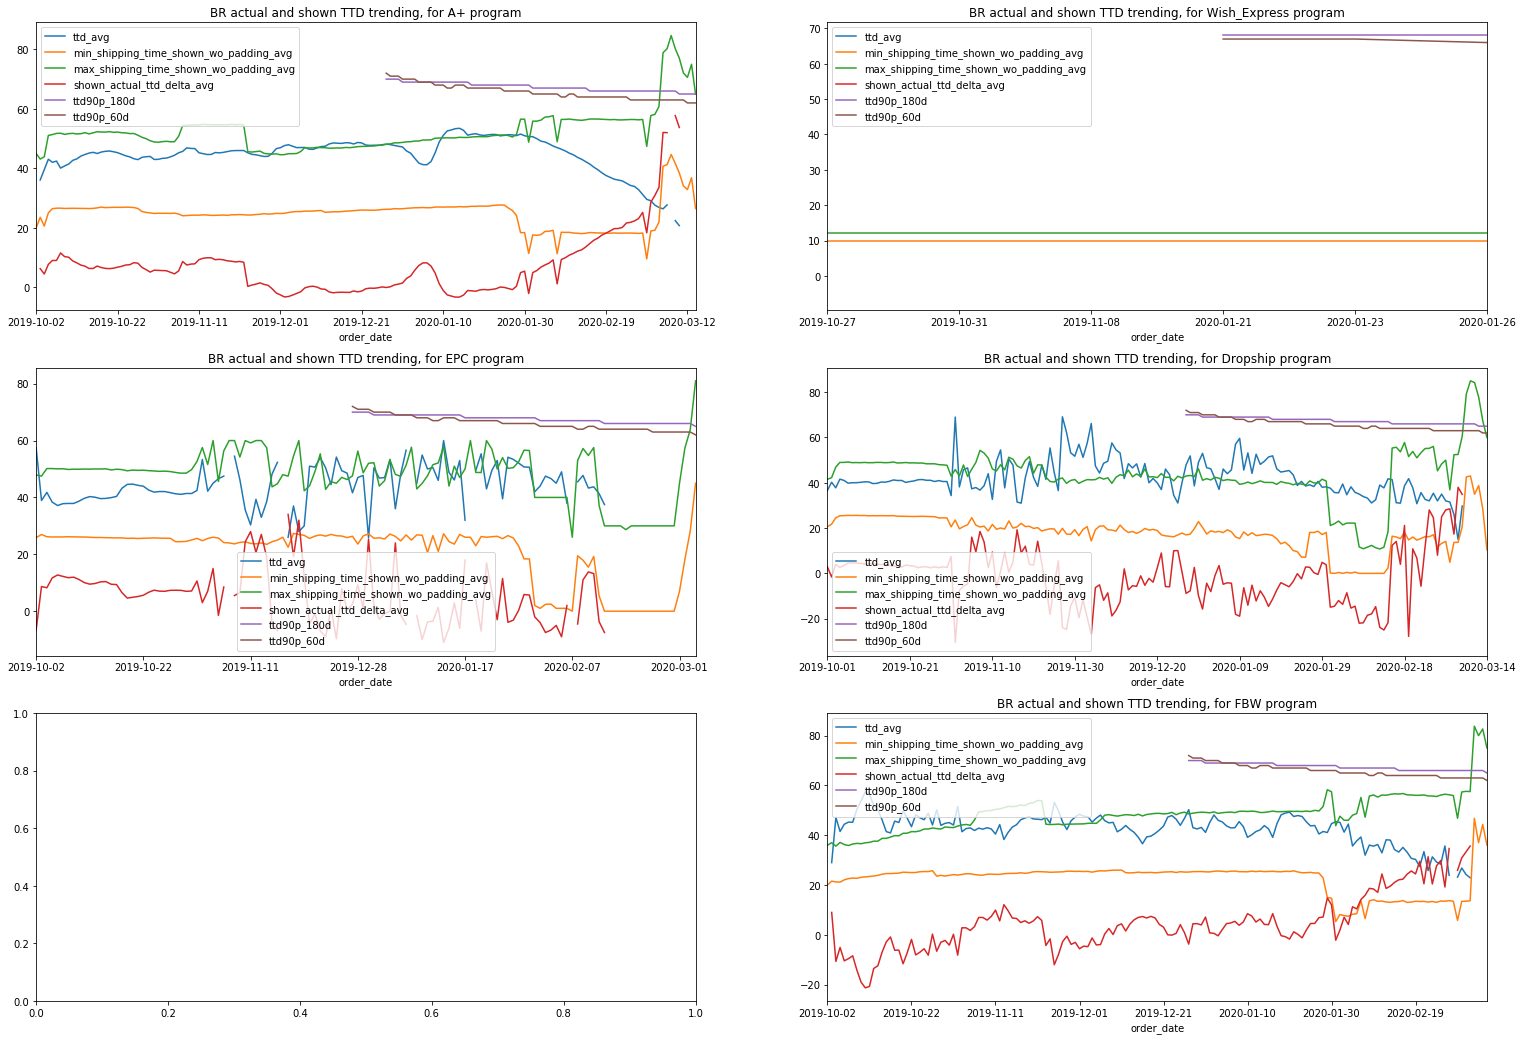

In [517]:
chart_actual_shown_TTD_trend_over_time('BR')

### France

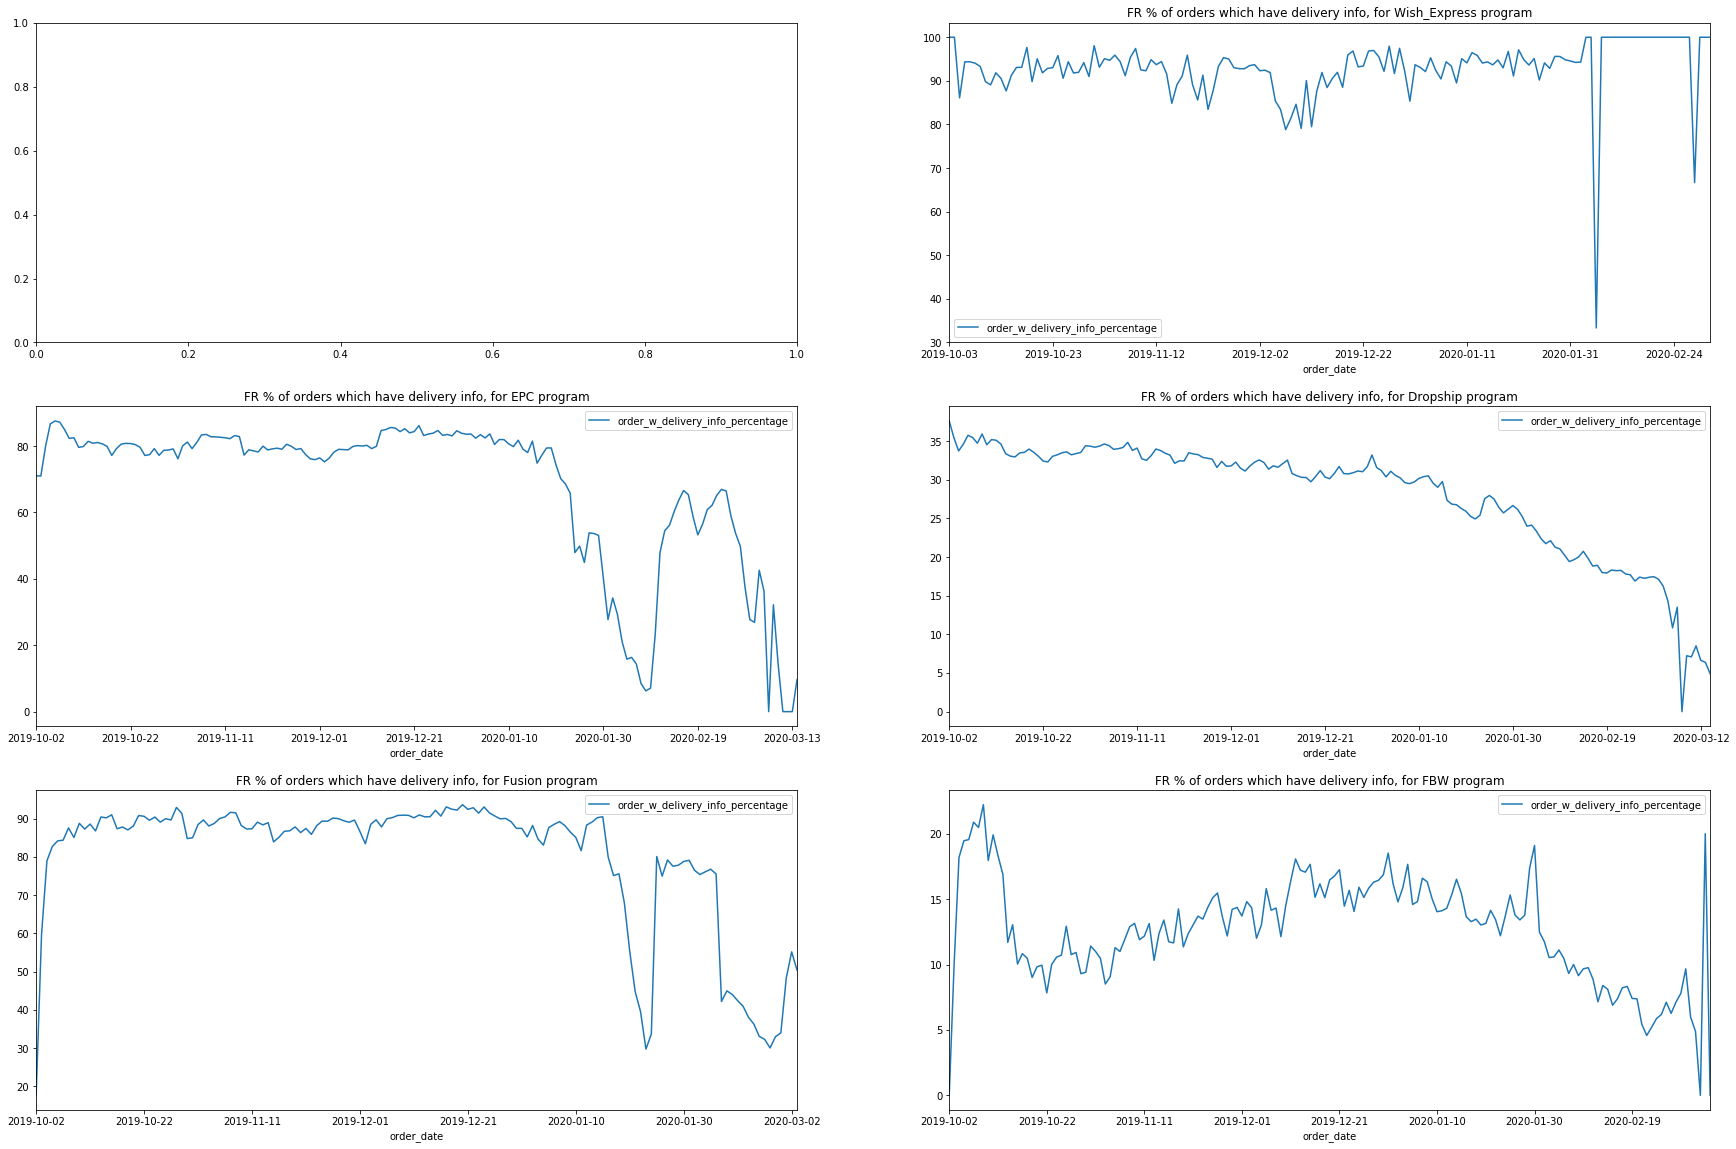

In [507]:
chart_delivery_coverage('FR')

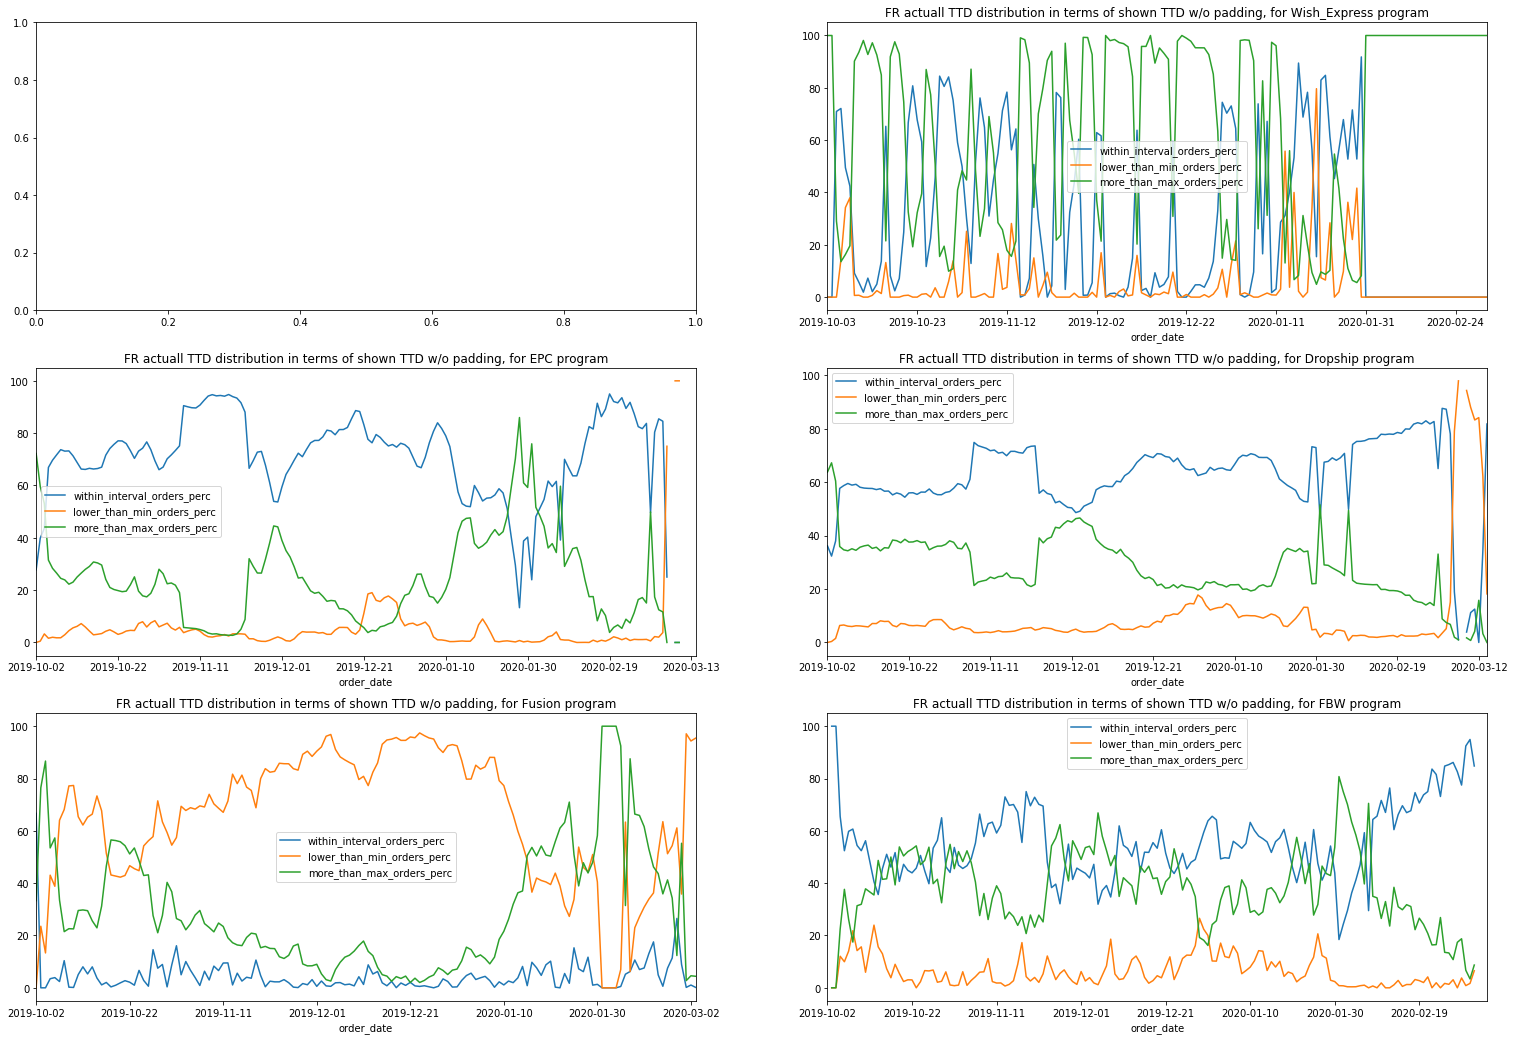

In [511]:
chart_actual_shown_TTD_relationship('FR')

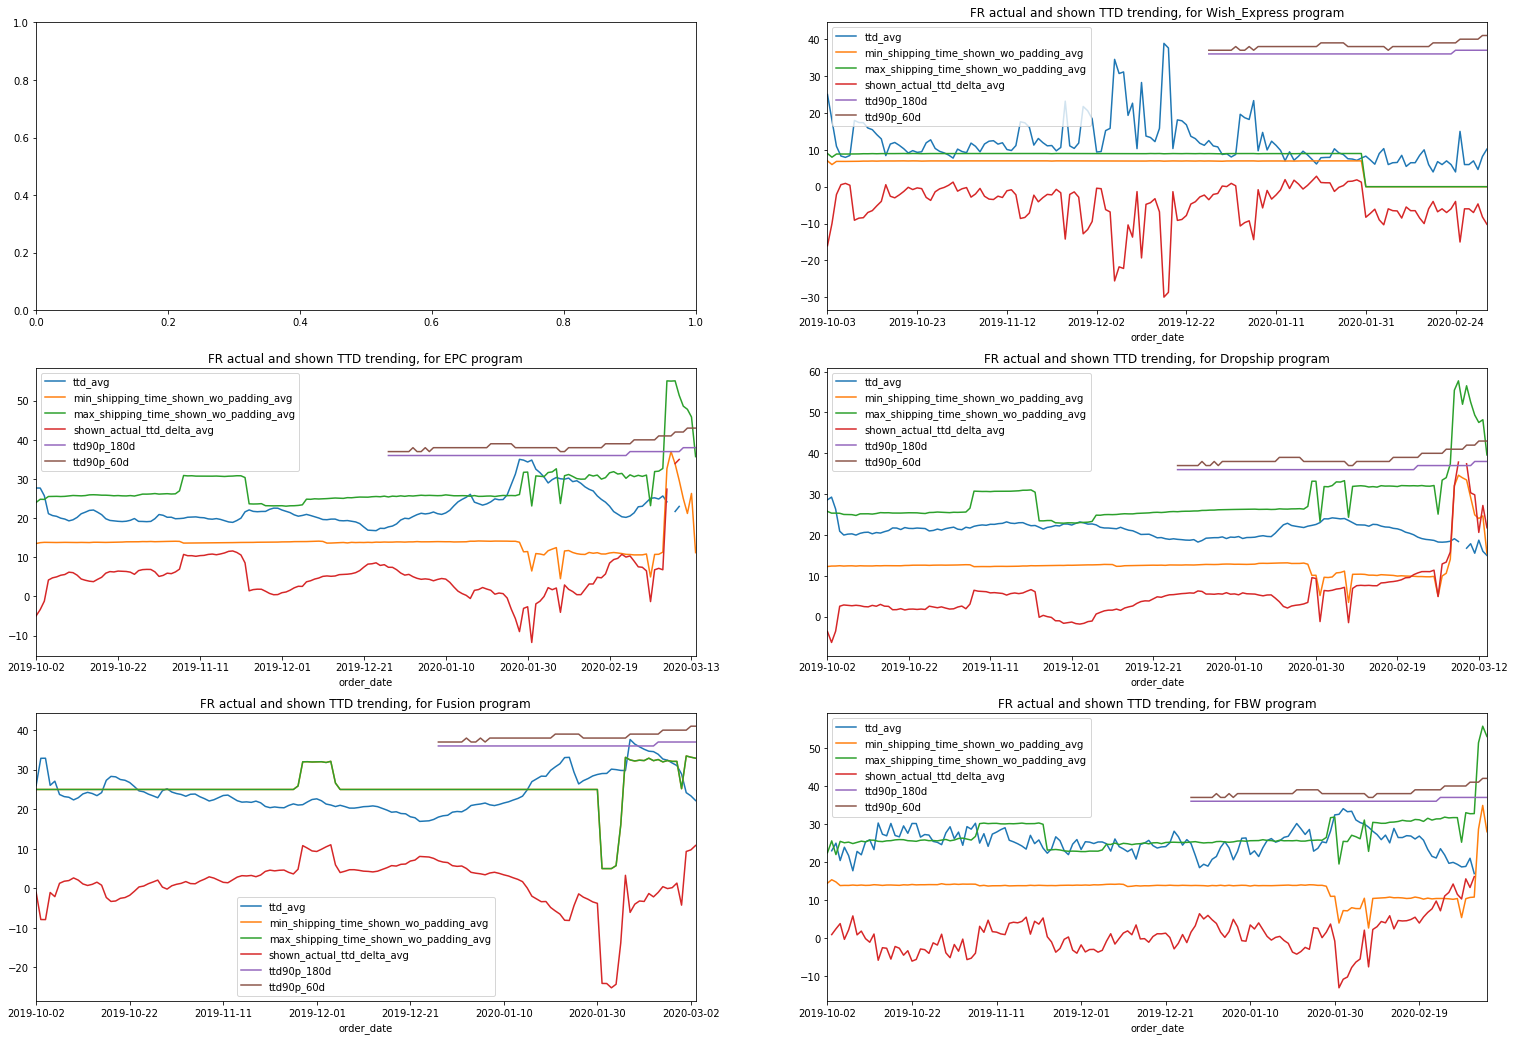

In [518]:
chart_actual_shown_TTD_trend_over_time('FR')

### Italy

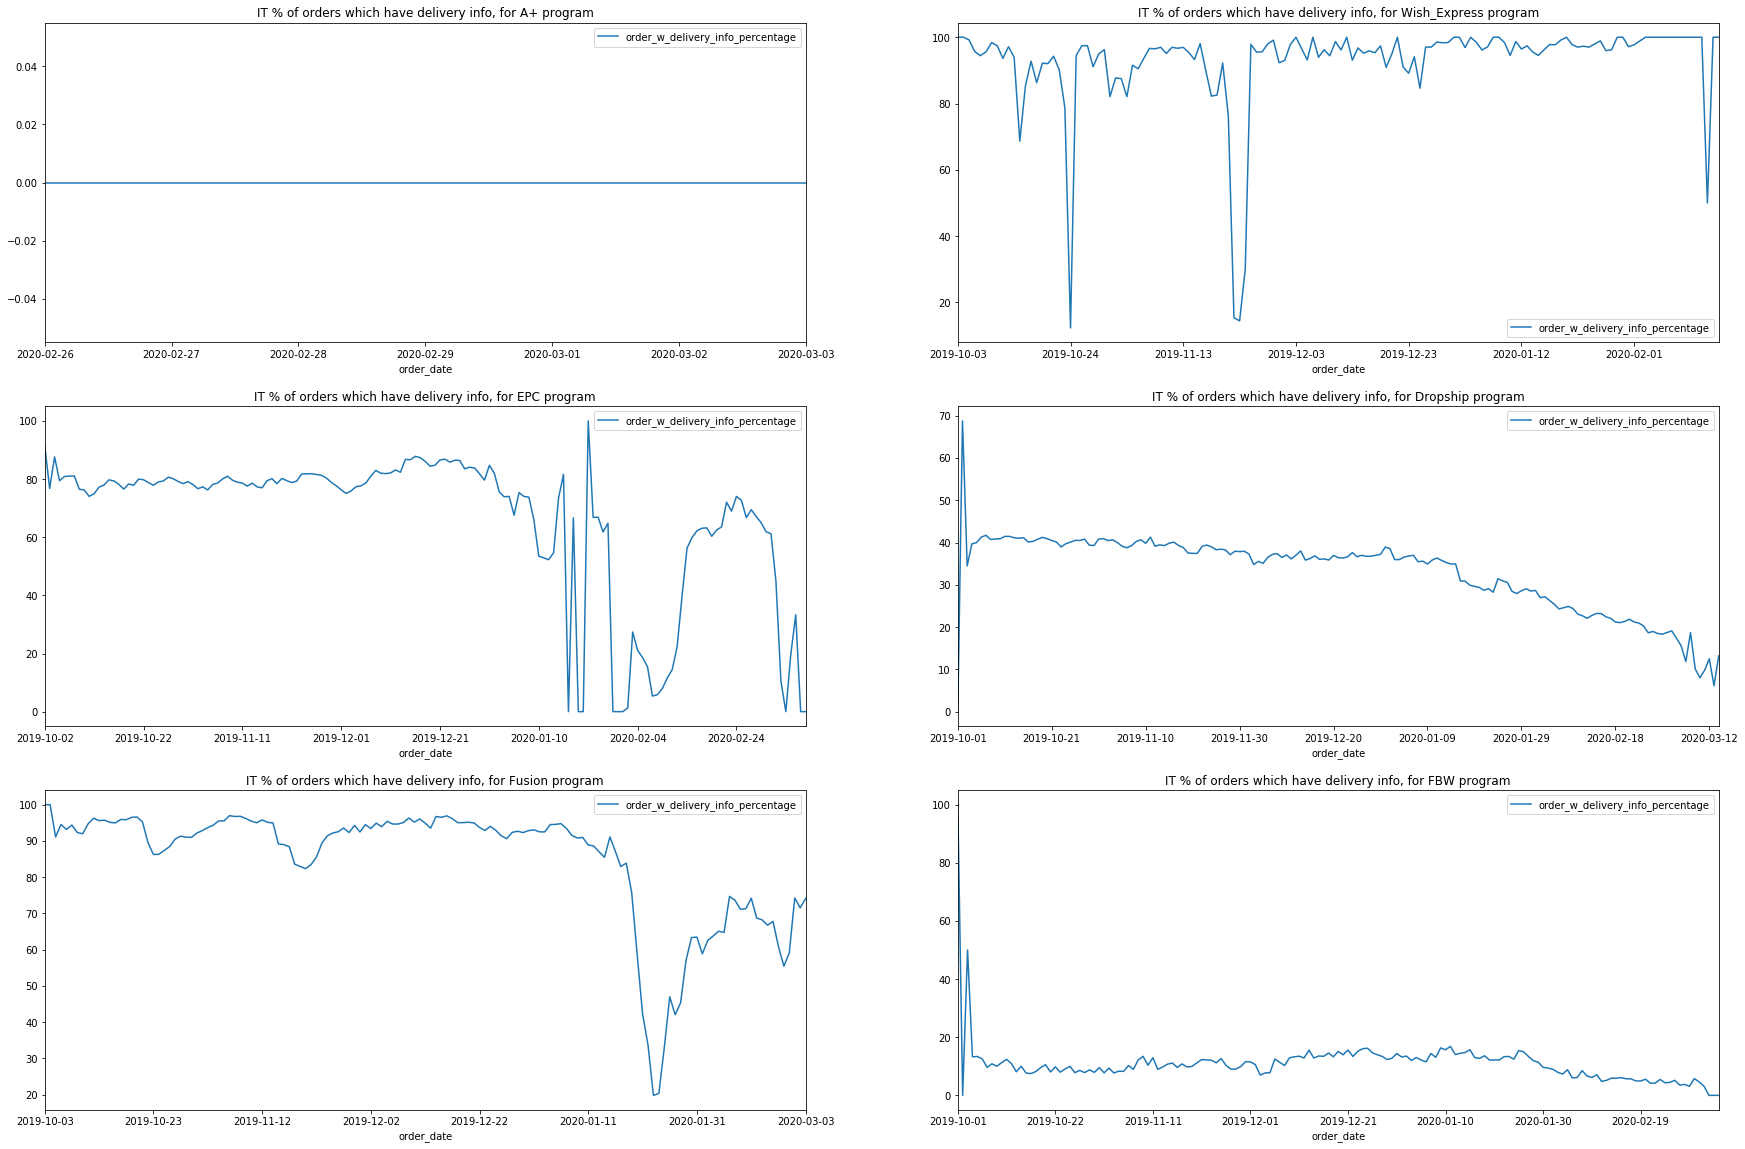

In [504]:
chart_delivery_coverage('IT')

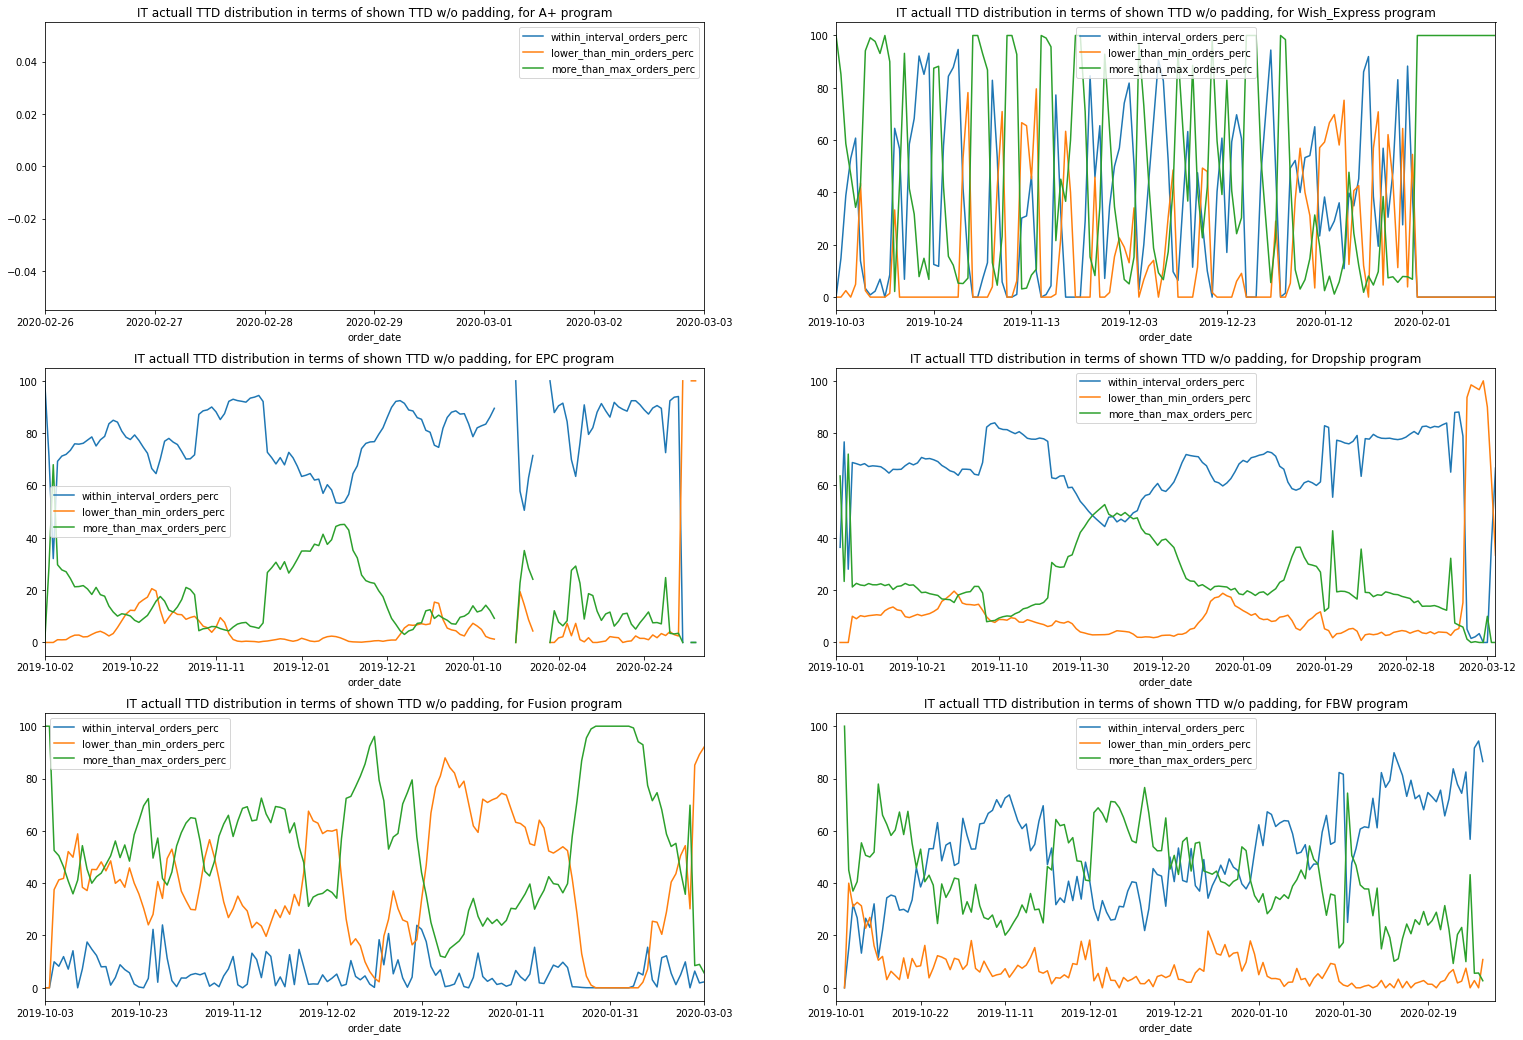

In [512]:
chart_actual_shown_TTD_relationship('IT')

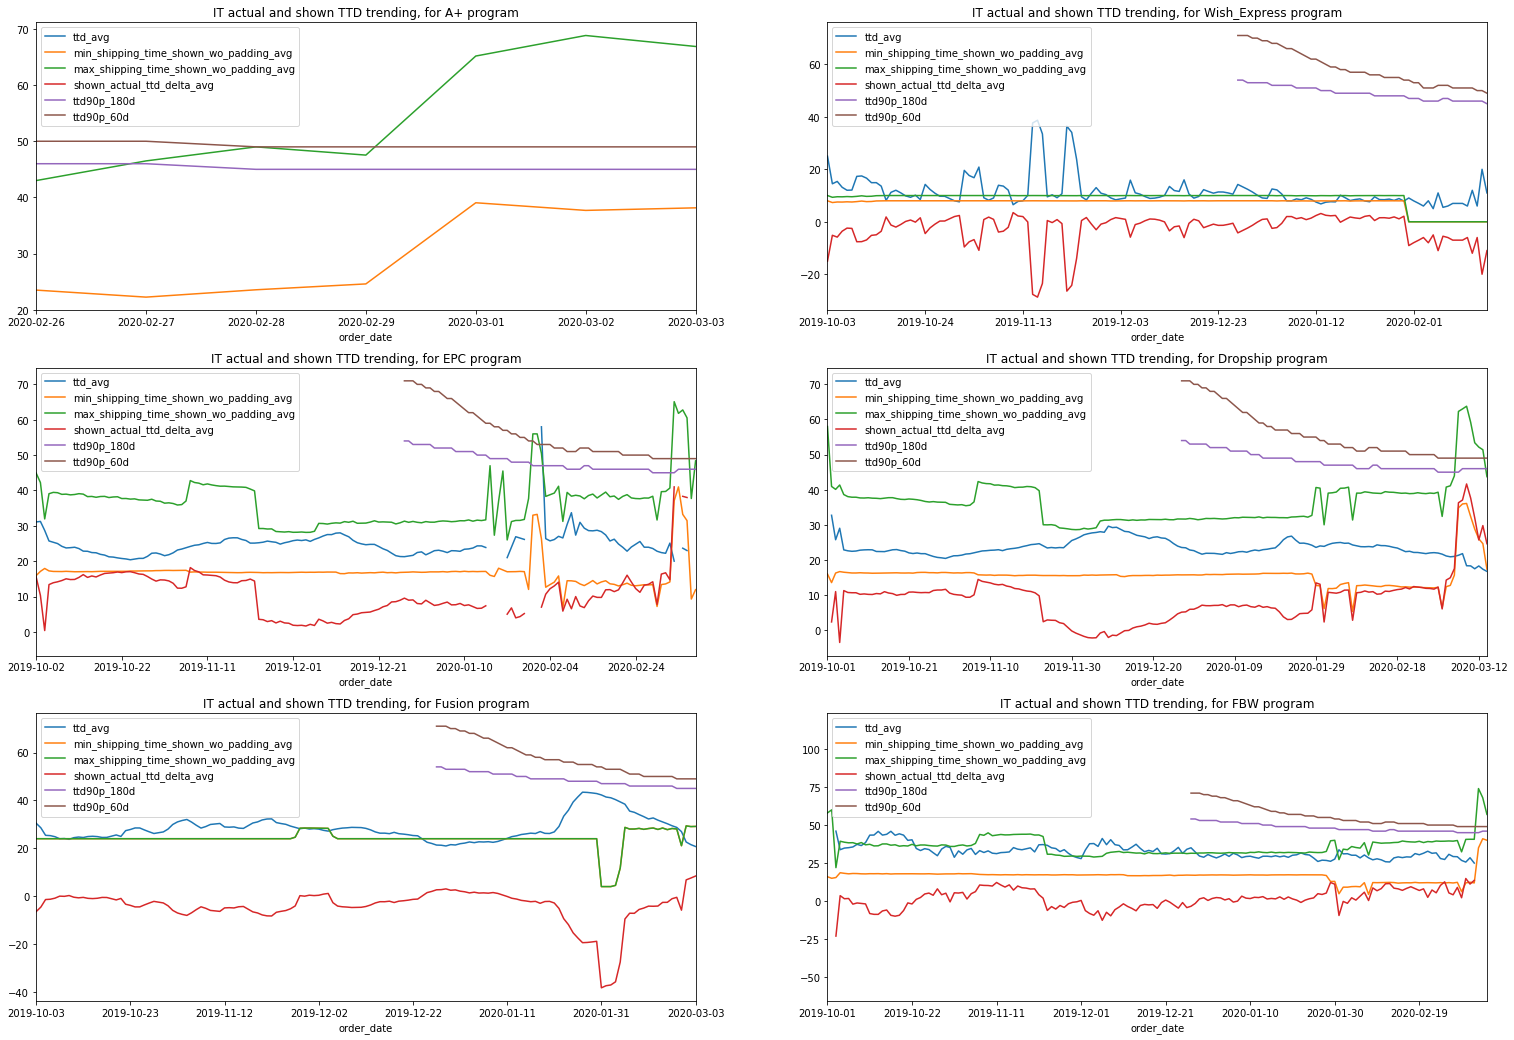

In [519]:
chart_actual_shown_TTD_trend_over_time('IT')

### Austrilia

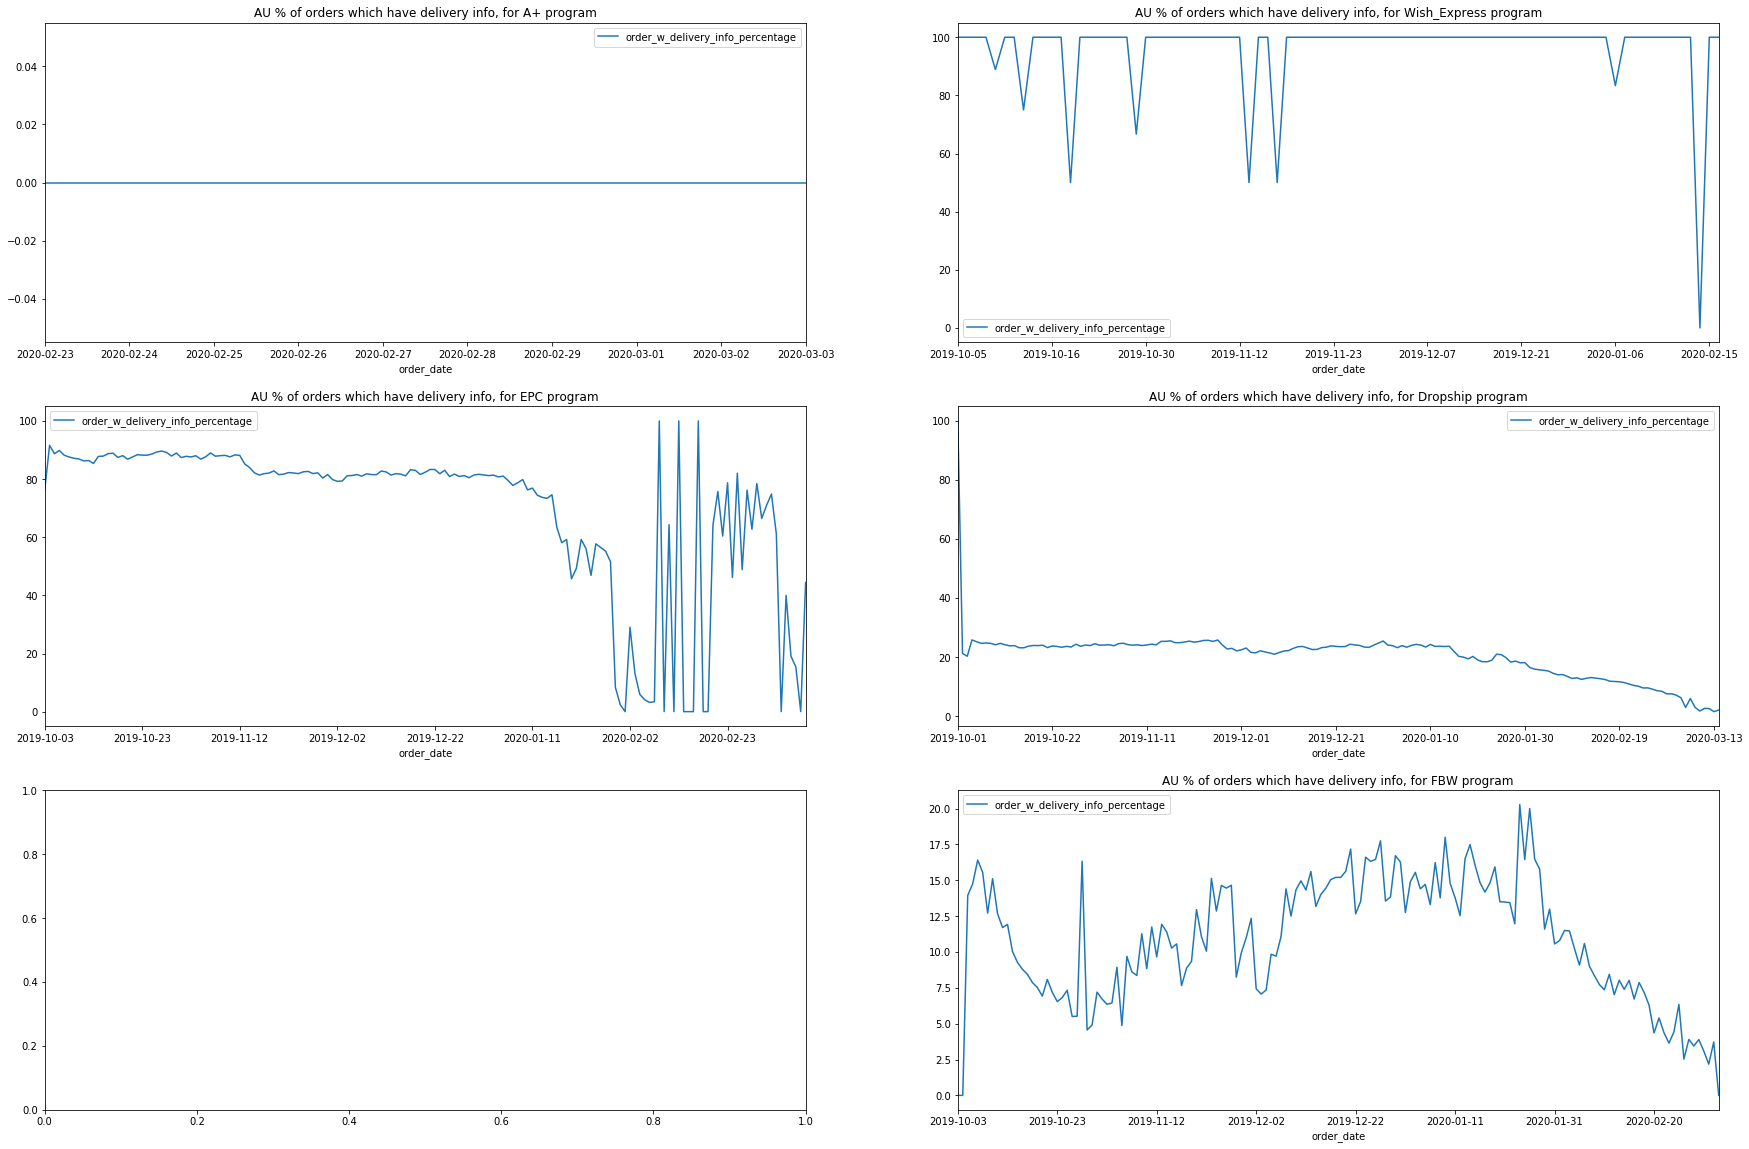

In [522]:
chart_delivery_coverage('AU')

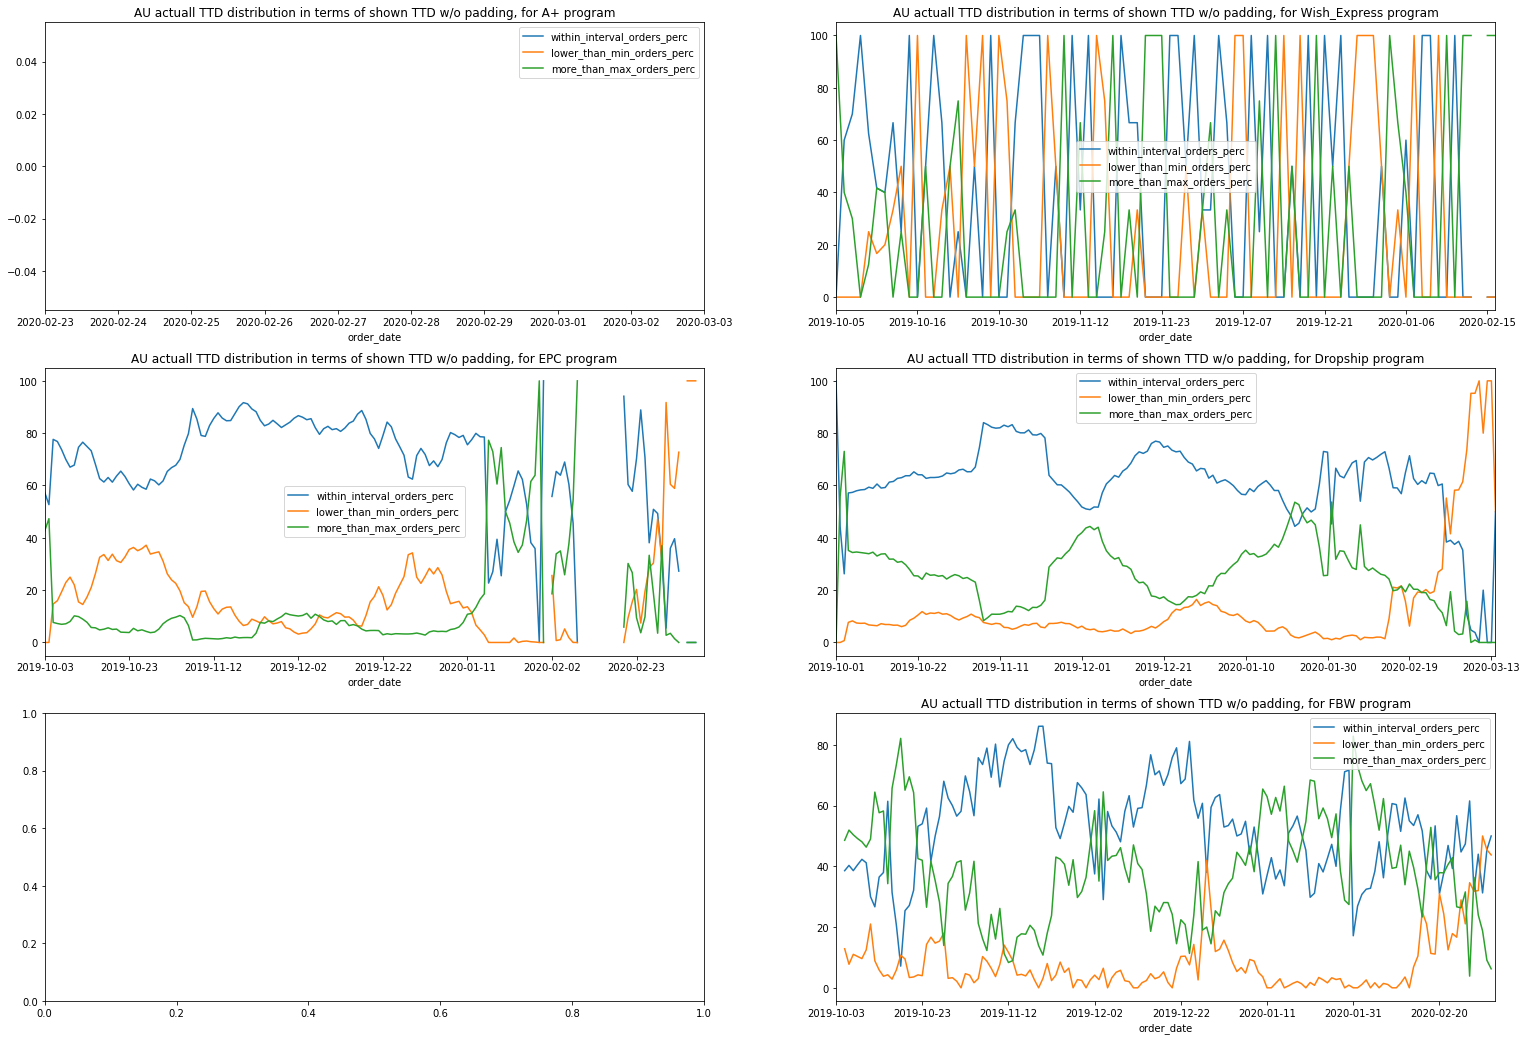

In [523]:
chart_actual_shown_TTD_relationship('AU')

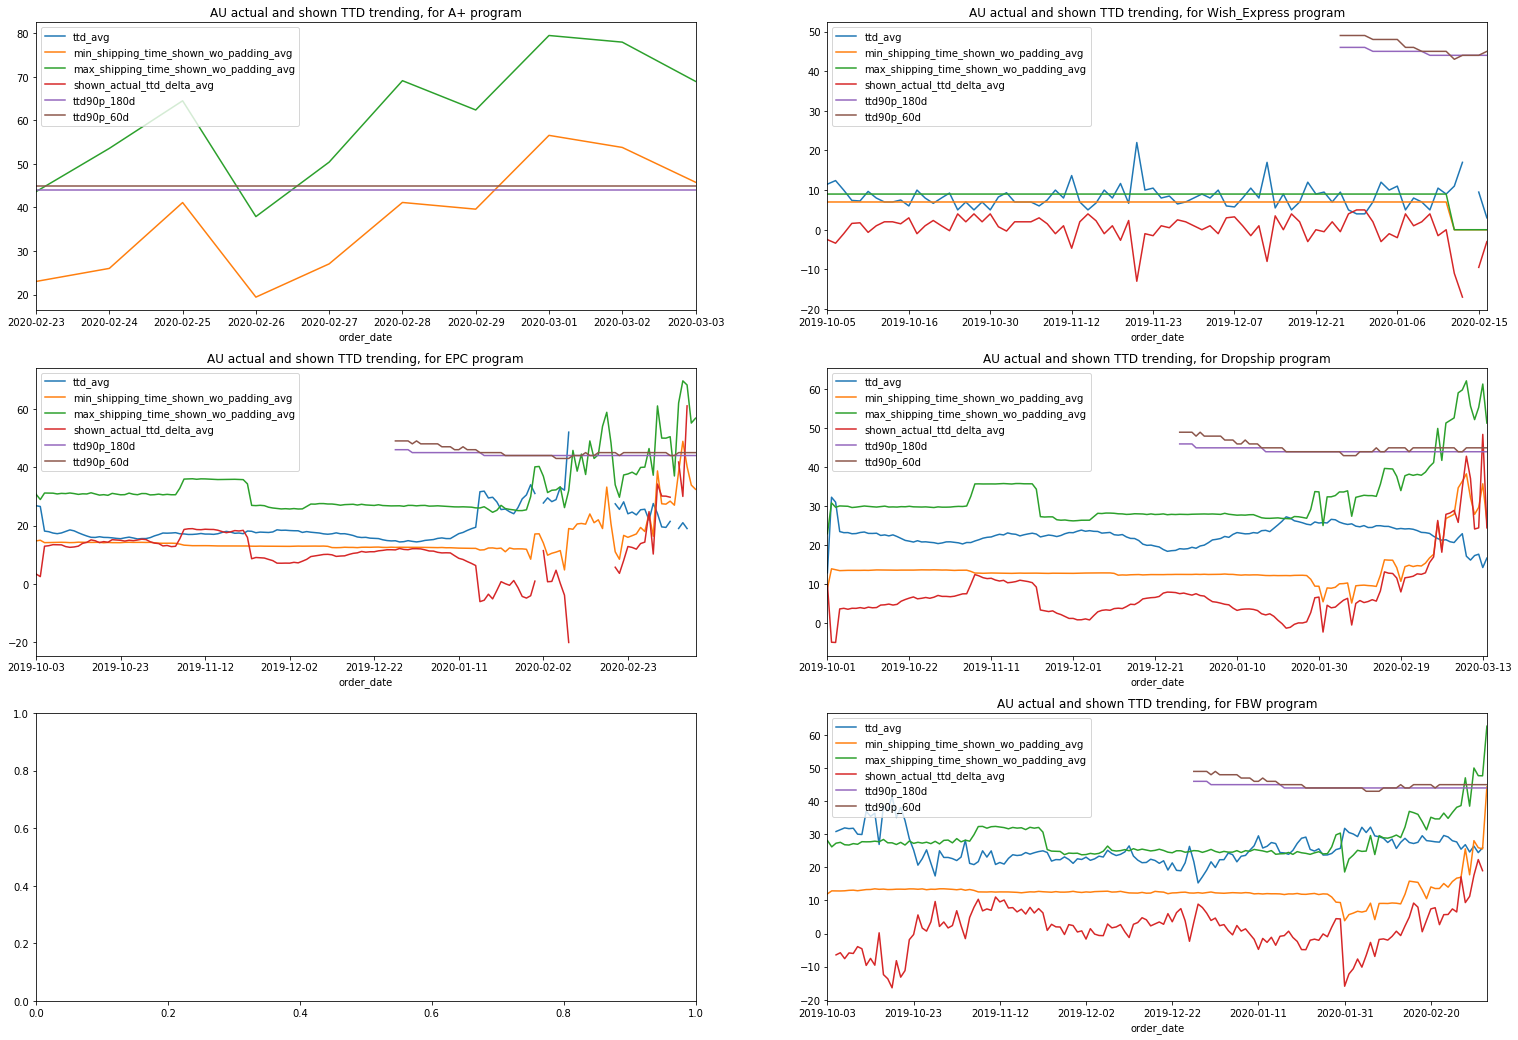

In [524]:
chart_actual_shown_TTD_trend_over_time('AU')